In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import cv2
import h5py
import pickle
import sys
import scipy.io
import re
from scipy.spatial import distance
from scipy.stats import zscore
from scipy.stats import zmap
%matplotlib inline

dir = r"D:\2024-01-08_ALC6_day4"
data_path = os.path.join(dir, '02-processed')
npy_path = os.path.join(dir, '00-npy files')
raw_path = os.path.join(dir, '01-raw')

mouse4 = 'ALC4'
mouse6 = 'ALC6'
h5_path_4 = os.path.join('D:/np_analysis', f'{mouse4}.h5')
h5_path_6 = os.path.join('D:/np_analysis', f'{mouse6}.h5')

combined = 'combined'
h5_path_combo = os.path.join('D:/np_analysis', f'{combined}.h5')



In [2]:
def importphy(folderpath, tipDepth=4000, sampleRate=30000):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to kilosort output
        2. `tipDepth` - int/float, depth of the shank tip in microns (Reading of D axis given by sensapex micromanipulator)
        3. `sampleRate` - int sample rate in Hz (find in params.py if unknown)
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `goodSpikes` - ndarray of clusters (unit identities of spikes)
        3. `goodSamples` - ndarray of spike samples (time of spike)
        4. `goodTimes` - ndarray of spike times (in s)
        5. `clusterIDs` - ndarray of unit index as listed in the Kilosort/Phy output
        6. `goodIDs` - ndarray of all units included in goodSpikes
        7. `depths` - ndarray of recording site depth, order match with `clusterID` (counting the depth of shank)
        8. `nSpikes` - ndarray of number of spikes 

        ## Not yet implemented
        1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
        2. `depthIndices` - index of good units in the order of their depth
        3. `layers` - the cortical layer to which the depth corresponds
        4. 'waveforms of unit at its best site'
    """
    # parameters
    tipLength = 175 # the tip length of neuropixel 1.0 [unit: µm]

    # import the Kilosort data
    clusterInfo = pd.read_csv(folderpath+'/cluster_info.tsv',sep='\t')
    spikeClusters = np.load(folderpath+'/spike_clusters.npy')
    spikeTimes = np.load(folderpath+'/spike_times.npy')

    # apply label from manual curation 
    clusterInfo.loc[clusterInfo['group'] == 'good', 'KSLabel'] = 'good'

    # store units with good qualities
    try:
        goodIDs = np.array(clusterInfo['id'][clusterInfo['KSLabel'] == 'good'])
    except KeyError:
        goodIDs = np.array(clusterInfo['cluster_id'][clusterInfo['KSLabel'] == 'good'])
    
    # compute the depth
        siteDepth = tipDepth - tipLength - np.array(clusterInfo['depth'])
        if any(depth < 0 for depth in siteDepth):
            print("Warning: Negative depth value found, changing to 0.")
            siteDepth = [0 if depth < 0 else depth for depth in siteDepth]

    # write the output
    outDict = {}
    outDict['sampleRate'] = sampleRate
    outDict['goodSpikes'] = spikeClusters[np.array([n in goodIDs for n in spikeClusters])]
    outDict['goodSamples'] = np.int64(spikeTimes[np.array([n in goodIDs for n in spikeClusters])].reshape(-1))
    outDict['goodTimes'] = outDict['goodSamples']/sampleRate
    outDict['clusterIDs'] = np.array(clusterInfo['cluster_id']) ## to get a list of cluster ids
    outDict['goodIDs'] = goodIDs
    outDict['depths'] =  siteDepth
    outDict['nSpikes'] = np.array(clusterInfo['n_spikes']) ## to get number of spikes 
    #outDict['depthIndices'] = np.argsort(clusterInfo['depth']) ## to get an index to use for sorting by depth

    # print the number of good neurons
    print("Number of neurons passing the quality check: {}".format(len(goodIDs)))

    # report the sampling frequency
    print("Sampling frequency: {} Hz.".format(outDict['sampleRate']))
    
    return outDict

In [3]:
def importnpy(dir):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to folder containing numpy arrays from NP_Optical trials
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `mechTrialForce` - array of all successfully recorded trials and their forces
        3. `mechTrials` - int of the number of successfully recorded mech trials
        

        ## Not yet implemented
        

    """
    import os
    import numpy as np
    import re

    data_path = os.path.join(dir, '02-processed').replace('\\', '/')
    npy_path = os.path.join(dir, '00-npy files').replace('\\', '/')
    raw_path = os.path.join(dir, '01-raw').replace('\\', '/')


    def mechTrialForce ():
        npy_files = [item for item in os.listdir(npy_path)]
        mech_files = [file for file in npy_files if 'mC_ai_data' in file]
        
        #1 sorting function to extract trial forces
        def sort_key(file):
            match = re.search(r'_(\d+).npy$', file)
            return int(match.group(1)) if match else float('inf')

        # Sort the mech trial files using the custom sorting function
        sorted_files = sorted(mech_files, key=sort_key)

        #extract forces in the proper trial order
        npy_Forces = []
        for sorted_file in sorted_files:
            match = re.search(r'_(\d+)mN_', sorted_file)
            force = int(match.group(1)) if match else None
            npy_Forces.append(force)
            


        #2 Extract trial numbers from successfully recorded mech trials (OpenEphys)
        recording_path = os.path.join(raw_path, '1-mechanical').replace('\\', '/')
        recordings = [item for item in os.listdir(recording_path) if os.path.isdir(os.path.join(recording_path, item))]
        recordings = sorted(recordings, key=lambda x: int(''.join(filter(str.isdigit, x))))

        # regex search of recordings for successfully recorded mech trials
        pattern = re.compile(r'recording(\d+)')
        successfulRecordings = []
        for recording in recordings:
            match = pattern.search(recording)
            if match:
                successfulRecordings.append(int(match.group(1)))

        # sort/return successfulRecordings list
        successfulRecordings = sorted(successfulRecordings)

        #list and export the forces for only the successfully recorded mech trial files
        mechTrialForce = [npy_Forces[i - 1] for i in successfulRecordings]
        

        return mechTrialForce

    def getMechDuration():
        #This function estimates the trial duration for mechanical stimulation trials for the given experimental dataset
        
        #Empty list will contain filepaths of recordings that are to be concatenated
        mech_files = []

        #01-raw contains folders for every experiment
        experiments = [item for item in os.listdir(raw_path) if os.path.isdir(os.path.join(raw_path, item))]

        for experiment in experiments:

            if experiment == '1-mechanical':
                #files_to_concat.append(path)
                recording_path = os.path.join(raw_path, experiment).replace('\\', '/')
                recordings = [item for item in os.listdir(recording_path) if os.path.isdir(os.path.join(recording_path, item))]
                recordings = sorted(recordings, key=lambda x: int(''.join(filter(str.isdigit, x))))

                for recording in recordings:
                    path = os.path.join(recording_path, recording,'continuous','Neuropix-PXI-100.ProbeA-AP','continuous.dat').replace('\\', '/')
                    mech_files.append(path)
            else:
                pass
        
        #Calculate average recording lengths
        sample_lengths = []
        for file in mech_files:
            try:
                # Get the length of the binary data
                file_size = os.path.getsize(file)
                if (file_size/30000/385/2) >= 4: # Just in case I get a wildly low value from an aborted recording (e.g., ALC6, day2)
                    sample_lengths.append((file_size/30000/385/2))
            except FileNotFoundError:
                print(f"File '{file}' not found.")
            except Exception as e:
                print(f"An error occurred: {e}")
        mechDuration = np.mean(sample_lengths)
        return mechDuration
    

    try:
        mech_trial_force = mechTrialForce()
        hasMech = True
    except FileNotFoundError:
        hasMech = False
        pass
    except Exception as e:
        hasMech = False
        print("An error occurred:", e)


    #Exports
    outDict = {}
    outDict['sampleRate'] = sampleRate
    if hasMech:
        try:
            outDict['mechTrialForce'] = mech_trial_force
            outDict['mechTrials'] = len(mech_trial_force)
            outDict['mechDuration'] = getMechDuration()
        except Exception as e:
            print("An error occurred:", e)


    return outDict

In [282]:
## Process and save h5 files with all spike data for each mouse.

# Get list of files to be analyzed
dp_pattern = re.compile(r'ALC\d_day\d')
datapoint_files = [filename for filename in os.listdir('D:/') if dp_pattern.search(filename)]

# Helper function to save acquired data in h5 file for each mouse as you get it
def save_data_to_group(group, data_name, data):
    if data_name in group:
        print(f'{data_name} already exists for data group {group}.')
        
    else:
        group[data_name] = data


# Core loop to load through each datapoint file
for filename in datapoint_files:
    #initialize filepath names
    dir = f"D:/{filename}"
    data_path = os.path.join(dir, '02-processed')
    npy_path = os.path.join(dir, '00-npy files')
    raw_path = os.path.join(dir, '01-raw')

    # Extract mouse_name and exp_day
    pattern = r"_([A-Za-z0-9]+)_(day\d+)"
    match = re.search(pattern, dir)
    if match:
        mouse_name = match.group(1)
        exp_day = match.group(2)
    else:
        print("!!! Pattern not found in the 'dir' string.")
    print(f'Processing {mouse_name}, {exp_day}...')

    # Import Phy data
    spikeDict = importphy(data_path, tipDepth=4050, sampleRate=30000)
    goodSamples = np.array(spikeDict['goodSamples'])
    goodSpikes = np.array(spikeDict['goodSpikes'])
    goodTimes = np.array(spikeDict['goodTimes'])
    sampleRate = np.array(spikeDict['sampleRate'])
    depths = np.array(spikeDict['depths'])
    clusterIDs = np.array(spikeDict['clusterIDs'])

    # Import NPY-saved data
    npyDict = importnpy(dir)
    if len(npyDict) > 1:
        mechTrialForce = npyDict['mechTrialForce']
        mech_duration = npyDict['mechDuration']
        hasMech = True
    else:
        hasMech = False

    # Get laser trial durations:
    def get_acRecField_duration():
        file = os.path.join(raw_path,r"2-acRecField\continuous\Neuropix-PXI-100.ProbeA-AP\continuous.dat")
        file_size = os.path.getsize(file)
        acRecField_duration = file_size/385/2 # duration in samples
        return acRecField_duration
    
    def get_physio_duration():
        file = os.path.join(raw_path,r"3-physio\continuous\Neuropix-PXI-100.ProbeA-AP\continuous.dat")
        file_size = os.path.getsize(file)
        physio_duration = file_size/385/2 # duration in samples
        return physio_duration

    def get_laser_duration():
        laser_trials = ['4-5hz pulsed', '5-20hz pulsed', '6-40hz pulsed']
        durations = []
        for laser_trial in laser_trials:
            file = os.path.join(raw_path, laser_trial, r"continuous\Neuropix-PXI-100.ProbeA-AP\continuous.dat")
            file_size = os.path.getsize(file)
            durations.append(file_size/385/2)
        laser_duration = np.nanmean(durations) # avg laser duration in samples
        return laser_duration
    
    try:
        acRecField_duration = get_acRecField_duration()
        physio_duration = get_physio_duration()
        laser_duration = get_laser_duration()
        hasLaser = True
    except FileNotFoundError:
        hasLaser = False
        pass
    except Exception as e:
        hasLaser = False
        print("!!! An error occurred:", e)



    # Create data dict to-be-saved
    data_to_save = {
        'sampleRate': sampleRate,
        'goodSpikes': goodSpikes,
        'goodSamples': goodSamples,
        'goodTimes': goodTimes,
        'depths': depths,
        'clusterIDs': clusterIDs,
        # 'selected_units': selected_units,
        # 'selected_unit_depths': selected_unit_depths,
        # 'cortical_selected_units': cortical_selected_units,
        # 'thalamic_selected_units': thalamic_selected_units,
        # Add more datasets as needed
    }
    if hasMech:
        data_to_save['mech_duration'] = mech_duration
        data_to_save['mechTrialForce'] = mechTrialForce
    else:
        print(f'!!! No mech data saved for {mouse_name} {exp_day}.')
    if hasLaser:
        data_to_save['acRecField_duration'] = acRecField_duration
        data_to_save['physio_duration'] = physio_duration
        data_to_save['laser_duration'] = laser_duration
    else:
        print(f'!!! No laser data saved for {mouse_name} {exp_day}.')
    
    # Save to h5 file
    #savename = mouse_name
    savename = 'combined'
    h5_path = os.path.join('D:/np_analysis', f'{savename}.h5')

    with h5py.File(h5_path, 'a') as file:
        # Create or update the group for the current mouse
        groupname = f'{mouse_name}_{exp_day}'
        if groupname in file:
            exp_group = file[groupname]
        else:
            exp_group = file.create_group(groupname)

        # Create or update datasets for the additional data
        for data_name, data in data_to_save.items():
            save_data_to_group(exp_group, data_name, data)
    
    print(f'Data for {mouse_name}, {exp_day} saved successfully.')

print('Data proccessing complete.')

Processing ALC4, day1...
Number of neurons passing the quality check: 198
Sampling frequency: 30000 Hz.
!!! No mech data saved for ALC4 day1.
Data for ALC4, day1 saved successfully.
Processing ALC4, day2...
Number of neurons passing the quality check: 315
Sampling frequency: 30000 Hz.
!!! No laser data saved for ALC4 day2.
Data for ALC4, day2 saved successfully.
Processing ALC4, day3...
Number of neurons passing the quality check: 245
Sampling frequency: 30000 Hz.
Data for ALC4, day3 saved successfully.
Processing ALC4, day4...
Number of neurons passing the quality check: 319
Sampling frequency: 30000 Hz.
Data for ALC4, day4 saved successfully.
Processing ALC6, day1...
Number of neurons passing the quality check: 201
Sampling frequency: 30000 Hz.
Data for ALC6, day1 saved successfully.
Processing ALC6, day2...
Number of neurons passing the quality check: 169
Sampling frequency: 30000 Hz.
Data for ALC6, day2 saved successfully.
Processing ALC6, day3...
Number of neurons passing the qual

In [4]:
## Diplay an h5 file's structure.
with h5py.File(h5_path_combo, 'r') as file:
    # List all groups and datasets in the root
    print("Groups in the root:")
    for group in file:
        print(group)
    
    print('\nDatasets in each "ALC6_day1":')
    for dataset in file['ALC6_day1']:
        print(f' -{dataset}')
    # # Remove a group (replace 'group_to_remove' with your group name)
    # group_to_remove = 'ALC6_day4'
    # if group_to_remove in file:
    #     del file[group_to_remove]
    #     print(f"\n'{group_to_remove}' has been removed.")
    # else:
    #     print(f"\n'{group_to_remove}' not found.")

Groups in the root:
ALC4_day1
ALC4_day2
ALC4_day3
ALC4_day4
ALC6_day1
ALC6_day2
ALC6_day3
ALC6_day4

Datasets in each "ALC6_day1":
 -acRecField_duration
 -clusterIDs
 -depths
 -goodSamples
 -goodSpikes
 -goodTimes
 -laser_duration
 -mechTrialForce
 -mech_duration
 -physio_duration
 -sampleRate


In [5]:
def loadDataDictH5(filepath):
    with h5py.File(filepath, 'r') as hdf5_file:
        # Create an empty dictionary to store data for each group
        data_dict = {}

        # Iterate through each group in the HDF5 file
        for group_name in hdf5_file.keys():
            group = hdf5_file[group_name]

            # Create a dictionary to store arrays for the current group
            group_data = {}

            # Iterate through each dataset in the group
            for dataset_name in group.keys():
                array_data = np.array(group[dataset_name][...])
                group_data[dataset_name] = array_data

            # Add the group_data dictionary to the main data_dict
            data_dict[group_name] = group_data
        
        return data_dict

In [6]:
## Load H5 file and create a data_dict in working memory
alc6_dict = loadDataDictH5(h5_path_6)
alc4_dict = loadDataDictH5(h5_path_4)
combo_dict = loadDataDictH5(h5_path_combo)

#select the data dict to use for analysis in the rest of the code
data_dict = combo_dict
expts = data_dict.keys()
print(expts)

dict_keys(['ALC4_day1', 'ALC4_day2', 'ALC4_day3', 'ALC4_day4', 'ALC6_day1', 'ALC6_day2', 'ALC6_day3', 'ALC6_day4'])


2334


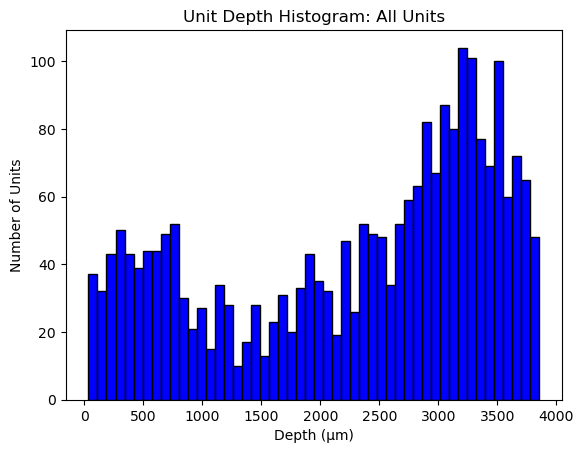

In [16]:
# Plotting depths of every recorded unit
all_depths = []

for expt in expts:
    if expt != 'ALC4_day1' and expt != 'ALC4_day2': #excludes the two expts that did not have complete datasets (i.e., laser AND mech)
        depths = np.array(data_dict[expt]['depths'])
        all_depths.extend(depths)

# Plotting the histogram
plt.hist(all_depths, bins=50, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Depth (μm)')
plt.ylabel('Number of Units')
plt.title('Unit Depth Histogram: All Units')

# Display the histogram
print(len(all_depths))
plt.show()

## 0.2 Plotting for mechanical stimultion

In [9]:
def loadExperiment(expt, data_dict):
    goodSamples = data_dict[expt]['goodSamples']
    goodSpikes = data_dict[expt]['goodSpikes']
    goodTimes = data_dict[expt]['goodTimes']
    sampleRate = data_dict[expt]['sampleRate']
    depths = data_dict[expt]['depths']
    clusterIDs = data_dict[expt]['clusterIDs']
    try:
        mechTrialForce = data_dict[expt]['mechTrialForce']
        mech_duration = data_dict[expt]['mech_duration']
    except KeyError:
        mechTrialForce = None
        mech_duration = None
    try:
        acRecField_duration = data_dict[expt]['acRecField_duration']
        physio_duration = data_dict[expt]['physio_duration']
        laser_duration = data_dict[expt]['laser_duration']
    except KeyError:
        acRecField_duration = None
        physio_duration = None
        laser_duration = None

    return goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration

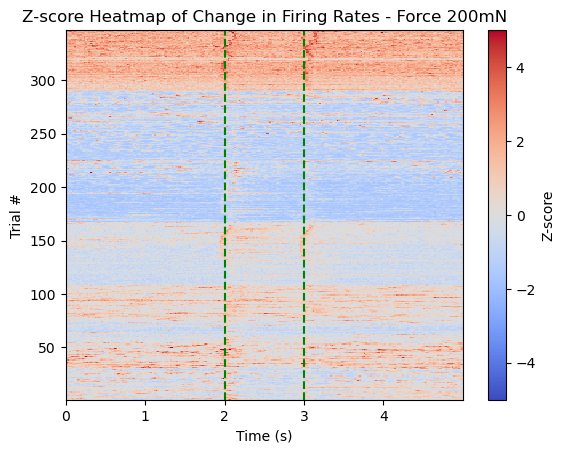

In [29]:
## Plot all mech trials (separated by force)
# Define trial parameters
sampleRate = 30000
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
mech_duration = 4.998
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram


total_trials = 0
change_in_firing_rates_list = []
baseline_firing_rates_list = []
all_mechTrialForce = []


for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True

    if hasMech and hasLaser:
        # Number of trials and bins
        num_trials = len(mechTrialForce)
        total_trials += num_trials
        all_mechTrialForce.extend(mechTrialForce)

        # Initialize arrays to store firing rates and stimulation signal
        change_in_firing_rates = np.zeros((num_trials, num_bins))
        baseline_firing_rates = np.zeros((num_trials, num_bins))

        # Process each trial
        for i in range(num_trials):
            start_index = i * int(sampleRate * mech_duration)
            end_index = (i + 1) * int(sampleRate * mech_duration)

            # Find indices within range
            trial_spikes_all_units = goodSamples[(goodSamples >= start_index) & (goodSamples <= end_index)]

            # Calculate firing rates for the trial using np.histogram
            firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

            # Calculate the average firing rate in the first 2 seconds
            baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
            baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
            
            # Store firing rates for each trial
            change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
            baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]
        
        change_in_firing_rates_list.append(change_in_firing_rates)
        baseline_firing_rates_list.append(baseline_firing_rates)

#Concat into full-length arrays
all_change_in_firing_rates = np.concatenate(change_in_firing_rates_list)
all_baseline_firing_rates = np.concatenate(baseline_firing_rates_list)

# Assuming mechTrialForce is a NumPy array
unique_forces = np.unique(all_mechTrialForce)

#Make each force plot
for force in unique_forces:
    # Filter trials based on force
    force_indices = np.where(all_mechTrialForce == force)[0]
    force_change_in_firing_rates = all_change_in_firing_rates[force_indices, :]
    force_baseline_firing_rates = all_baseline_firing_rates[force_indices, :]
    
    # Z-score the change in firing rates
    z_scored_change = zmap(force_change_in_firing_rates, force_baseline_firing_rates, axis=0, ddof=1)
    
    # Plotting
    time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
    trial_axis = np.arange(1, len(force_indices) + 1)

    # Create a z-score heatmap
    plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(force_indices)],
               cmap='coolwarm', origin='lower', vmin=-5, vmax=5, interpolation='none')  # Centered colormap

    # Add stimulation onset, hold, and ramp-down lines
    plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
    plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

    plt.xlabel('Time (s)')
    plt.ylabel('Trial #')
    plt.colorbar(label='Z-score')
    plt.title(f'Z-score Heatmap of Change in Firing Rates - Force {force}mN')
    plt.show()

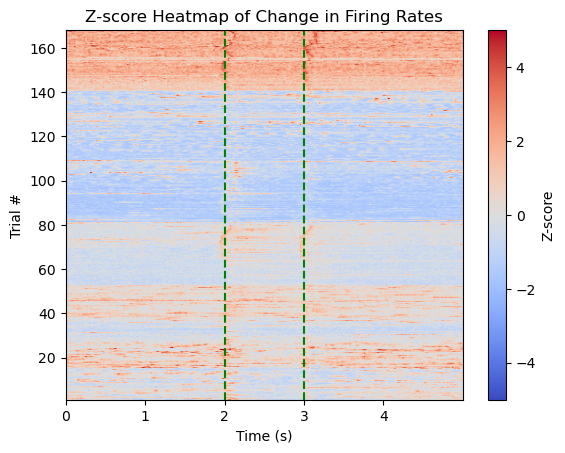

In [297]:
#Plot all mech trials (unseparated by force)
# Plotting
time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-5, vmax=5)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='green', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

#takes about 1.5 minutes

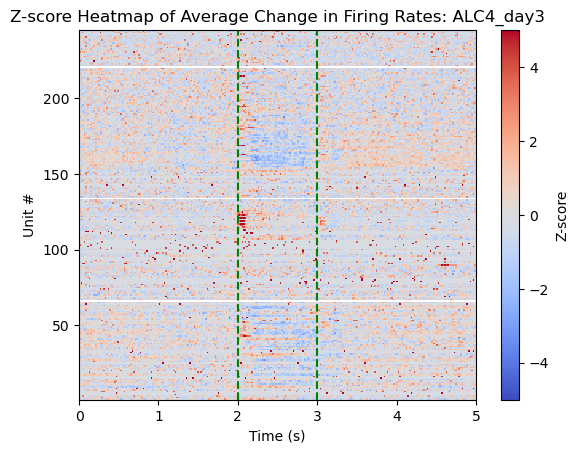

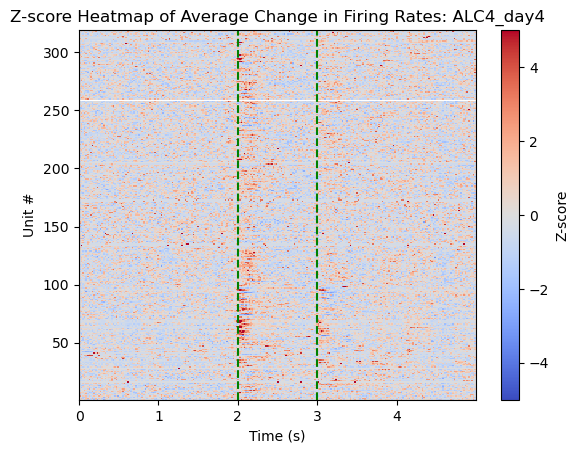

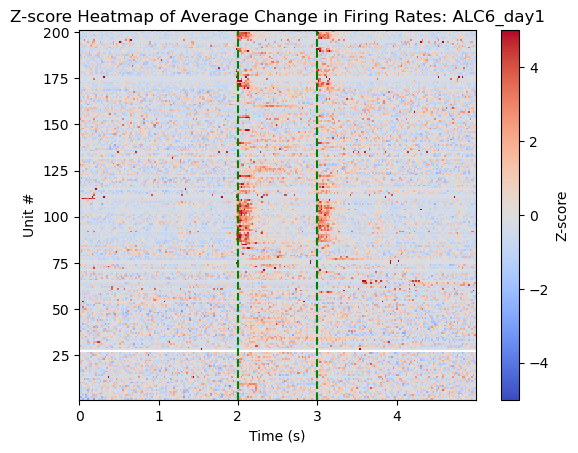

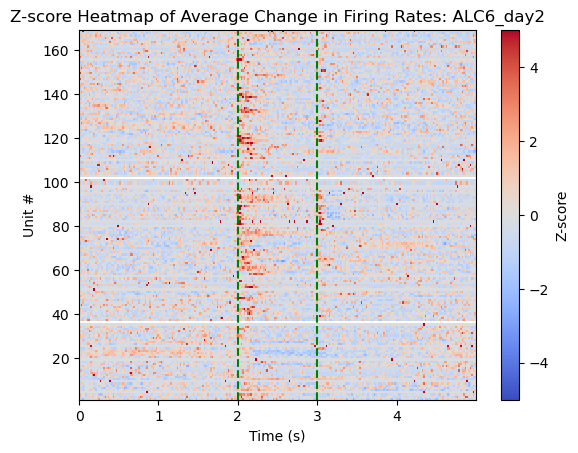

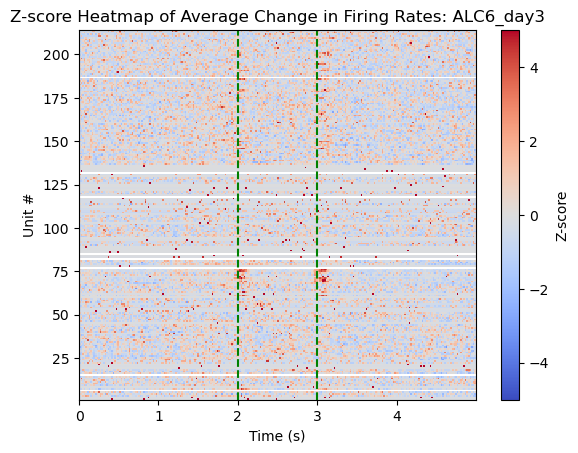

In [26]:
#Plot averaged unit responses in each experiment
#global parameters
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
bin_factor = 0.02 # the actual bin size in seconds.

#selected unit dicts to be created
expts_selected_units = {}
cortical_expts_selected_units = {}
thalamic_expts_selected_units = {}

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        bin_size = int(sampleRate * bin_factor) #bin size in samples.
        num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram
        num_trials = len(mechTrialForce)
        
        #adjust for differences in trial start time
        mech_adjustment = 0
        if expt == 'ALC4_day3':
            mech_adjustment = -(30000*.04)
        if expt == 'ALC4_day4':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day1':
            mech_adjustment = -(30000*.05)
        if expt == 'ALC6_day2':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day3':
            mech_adjustment = (30000*.07)
        if expt == 'ALC6_day4':
            mech_adjustment = -(30000*.01)

        #Plot z-scores separated by individual units in y-axis
        unique_units = np.unique(goodSpikes)

        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(unique_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(unique_units), num_bins))

        # Process each unit
        for i, unit in enumerate(unique_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = j * int(sampleRate * mech_duration) + mech_adjustment
                end_index = (j + 1) * int(sampleRate * mech_duration) + mech_adjustment

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.nanmean(np.concatenate((firing_rates[:int(2 / bin_factor)], firing_rates[-int(2 / bin_factor):])), axis=0)
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
        unit_axis = np.arange(1, len(unique_units) + 1)
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=None, ddof=1, nan_policy='omit')
        z_scored_change = zscore(average_change_in_firing_rates, axis=1, nan_policy='omit')

        plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(unique_units)],
                cmap='coolwarm', origin='lower', vmin=-5, vmax=5, interpolation='none')  # Centered colormap

        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
        plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='green', label='Ramp Down')

        plt.xlabel('Time (s)')
        plt.ylabel('Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'Z-score Heatmap of Average Change in Firing Rates: {expt}')
        plt.show()

        # Extract units with z-scores over 3 after onset and offset times.
        onset_start = int(2 / bin_factor)
        onset_end = int(2.05 / bin_factor)
        offset_start = int(3 / bin_factor)
        offset_end = int(3.05 / bin_factor)
        sustained_start = int(2.25 / bin_factor)
        sustained_end = int(2.75 / bin_factor)

        # Select units firing over the two time windows
        selected_units_onset = unique_units[np.mean(z_scored_change[:, onset_start:onset_end], axis=1) > 2]
        selected_units_offset = unique_units[np.mean(z_scored_change[:, offset_start:offset_end], axis=1) > 2]
        selected_units_sustained = unique_units[np.mean(z_scored_change[:, sustained_start:sustained_end], axis=1) > 1.5]


        # Combine selected units from both time windows
        selected_units = np.unique(np.concatenate((selected_units_onset, selected_units_offset, selected_units_sustained))).astype(int)
        # Create a boolean mask for goodSpikes in clusterIDs
        bool_mask = np.isin(clusterIDs, selected_units)
        # Use the mask to extract depths for goodSpikes
        selected_unit_depths = np.array(depths[bool_mask].astype(int))

        #sort selected units by their depths (shallowest first)
        sorted_indices = np.argsort(selected_unit_depths)[::-1]  # [::-1] will Reverse the order of sorted indices
        selected_units_sorted = selected_units[sorted_indices]
        selected_units = selected_units_sorted

        if expt in expts_selected_units:
            expts_selected_units[expt].update(selected_units)
        else:
            expts_selected_units[expt] = [selected_units]

        # Create a boolean mask for goodSpikes in clusterIDs
        bool_mask = np.isin(clusterIDs, selected_units)
        # Use the mask to extract depths for goodSpikes
        selected_unit_depths = np.array(depths[bool_mask].astype(int))

        cortical_selected_units = selected_units[selected_unit_depths < 1500]
        thalamic_selected_units = selected_units[selected_unit_depths >= 1500]

        if expt in cortical_expts_selected_units:
            cortical_expts_selected_units[expt].update(cortical_selected_units)
        else:
            cortical_expts_selected_units[expt] = [cortical_selected_units]
        
        if expt in thalamic_expts_selected_units:
            thalamic_expts_selected_units[expt].update(thalamic_selected_units)
        else:
            thalamic_expts_selected_units[expt] = [thalamic_selected_units]

In [27]:
# Plotting depths of every SELECTED recorded unit
selected_unit_dict = expts_selected_units
# selected_unit_dict = cortical_expts_selected_units
# selected_unit_dict = thalamic_expts_selected_units

all_depths = []

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
        
    if hasMech and hasLaser:
        selected_units = np.concatenate(selected_unit_dict[expt])
        
        bool_mask = np.isin(clusterIDs, selected_units) # Create a boolean mask for goodSpikes in clusterIDs
        selected_unit_depths = np.array(depths[bool_mask].astype(int)) # Use the mask to extract depths for goodSpikes
        
        all_depths.extend(selected_unit_depths)

# Plotting the histogram
plt.hist(all_depths, bins=50, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Depth (μm)')
plt.ylabel('Number of Selected Units')
plt.title('Unit Depth Histogram: Mechanically Responsive Units')

# Display the histogram
print(len(all_depths))
plt.show()

254


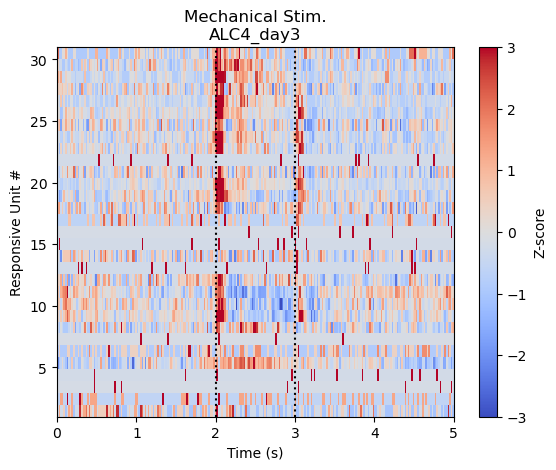

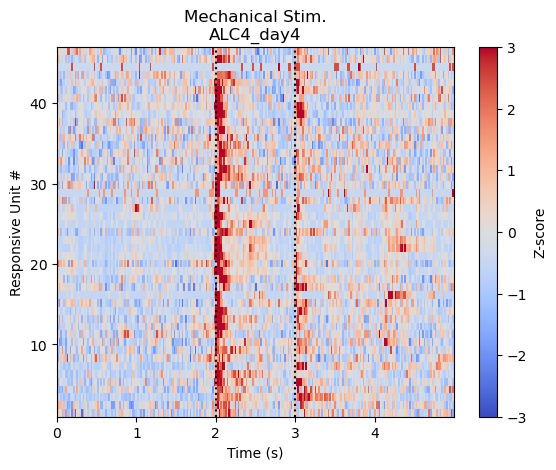

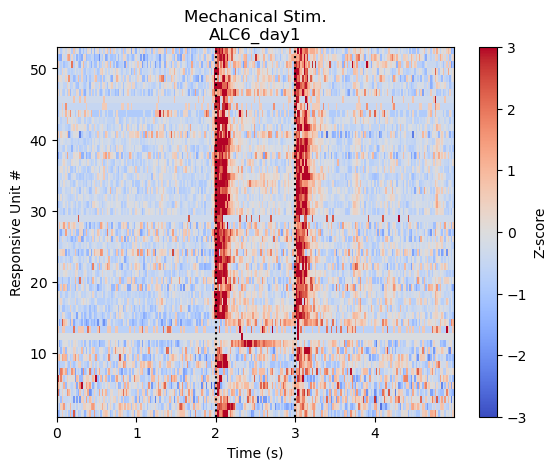

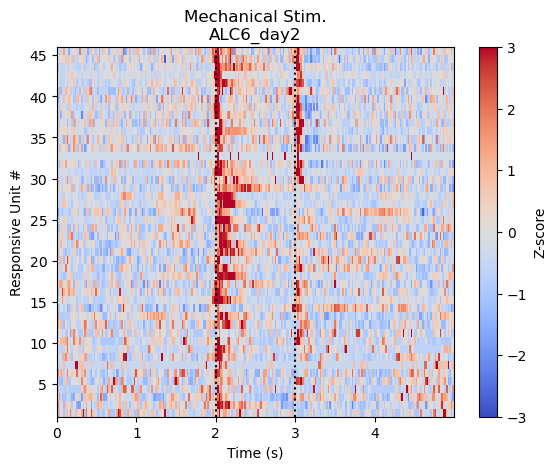

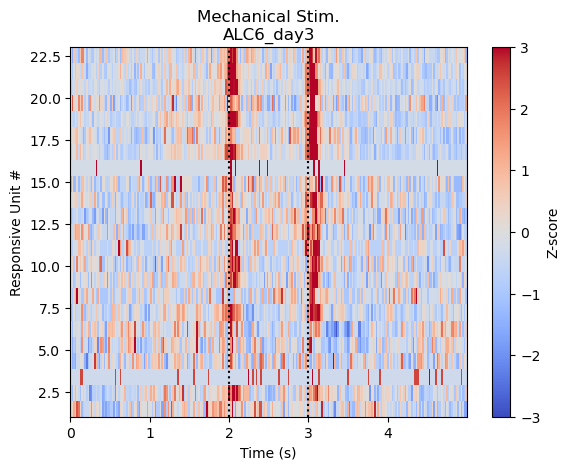

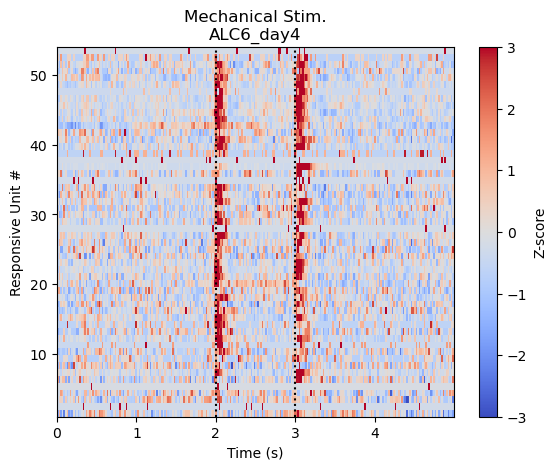

In [103]:
#plot mech trials by unit with enriched units
#global parameters
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
bin_factor = 0.02 # the actual bin size in seconds.

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True

    if hasMech and hasLaser:
        selected_units = np.concatenate(expts_selected_units[expt])
        
        # Define trial parameters
        bin_size = int(sampleRate * bin_factor) #bin size in samples.
        num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram
        num_trials = len(mechTrialForce)

        #adjust for differences in trial start time
        mech_adjustment = 0
        if expt == 'ALC4_day3':
            mech_adjustment = -(30000*.04)
        if expt == 'ALC4_day4':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day1':
            mech_adjustment = -(30000*.05)
        if expt == 'ALC6_day2':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day3':
            mech_adjustment = (30000*.07)
        if expt == 'ALC6_day4':
            mech_adjustment = -(30000*.01)

        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = j * int(sampleRate * mech_duration) + mech_adjustment
                end_index = (j + 1) * int(sampleRate * mech_duration) + mech_adjustment

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
        unit_axis = np.arange(1, len(selected_units) + 1)
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(selected_units)],
                cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap

        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black', label='Stimulation Onset')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black', label='Ramp Down')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'Mechanical Stim.\n{expt}')
        #plt.title(f'Z-score Heatmap of Average Change in Firing Rates-: {expt}')
        plt.show()

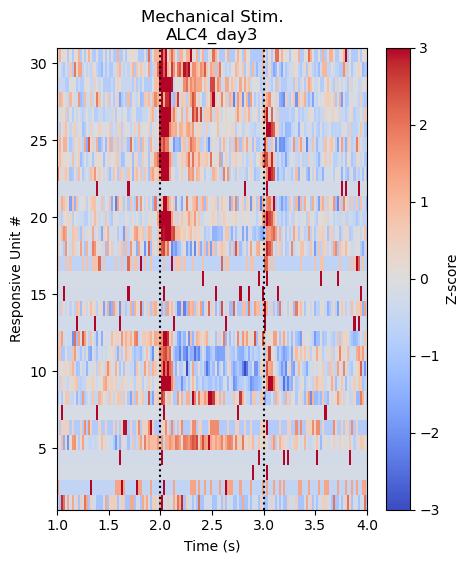

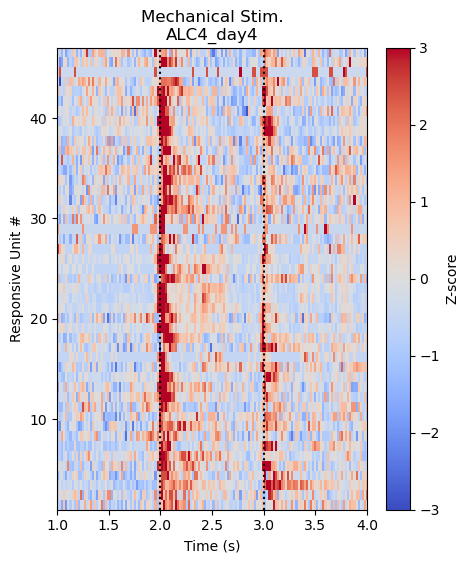

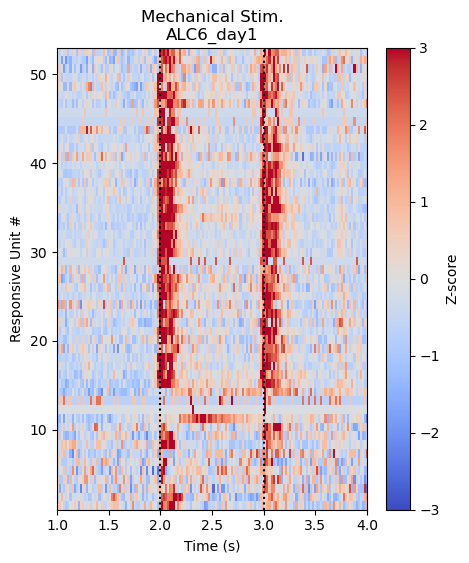

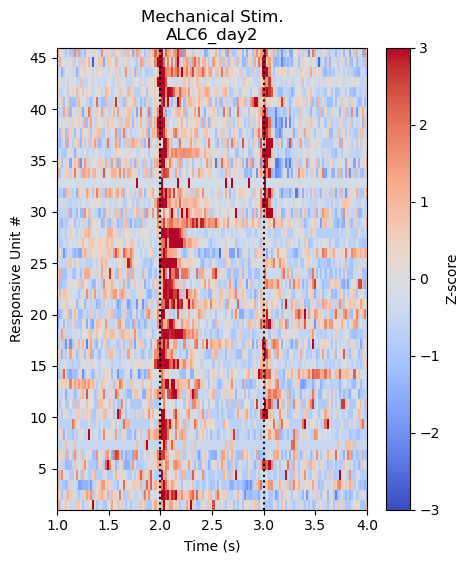

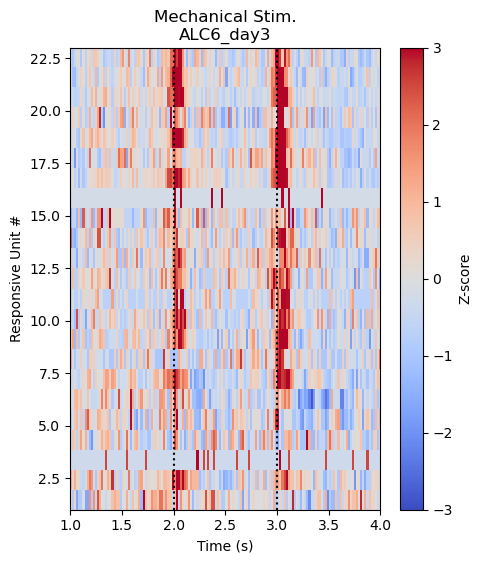

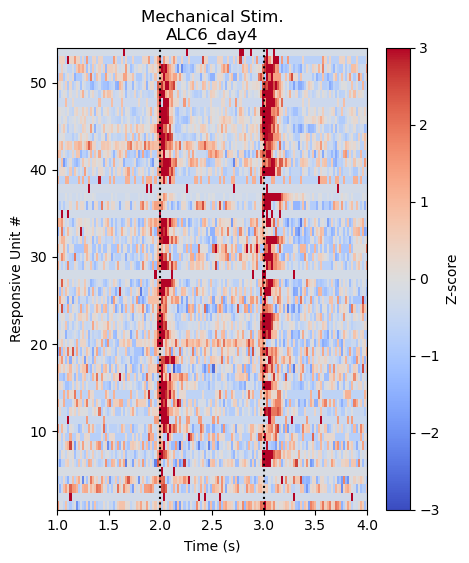

In [105]:
#TRUNCATED plot mech trials by unit with enriched units
#global parameters
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
bin_factor = 0.02 # the actual bin size in seconds.

# Plotting
# Define the time range you want to plot (between 2 and 4 seconds)
start_time = 1
end_time = 4
# Find the corresponding indices in the time_axis array
plot_start_bin = int(start_time / bin_factor)
plot_end_bin = int(end_time / bin_factor)


for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True

    if hasMech and hasLaser:
        selected_units = np.concatenate(expts_selected_units[expt])
        
        # Define trial parameters
        bin_size = int(sampleRate * bin_factor) #bin size in samples.
        num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram
        num_trials = len(mechTrialForce)

        #adjust for differences in trial start time
        mech_adjustment = 0
        if expt == 'ALC4_day3':
            mech_adjustment = -(30000*.04)
        if expt == 'ALC4_day4':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day1':
            mech_adjustment = -(30000*.05)
        if expt == 'ALC6_day2':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day3':
            mech_adjustment = (30000*.07)
        if expt == 'ALC6_day4':
            mech_adjustment = -(30000*.01)

        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = j * int(sampleRate * mech_duration) + mech_adjustment
                end_index = (j + 1) * int(sampleRate * mech_duration) + mech_adjustment

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
        unit_axis = np.arange(1, len(selected_units) + 1)
        plt.figure(figsize=(5, 6))

        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change[:, plot_start_bin:plot_end_bin], aspect='auto', extent=[start_time, end_time, 1, len(selected_units)],
           cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap

        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black', label='Stimulation Onset')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black', label='Ramp Down')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'Mechanical Stim.\n{expt}')
        #plt.title(f'Z-score Heatmap of Average Change in Firing Rates-: {expt}')
        plt.show()

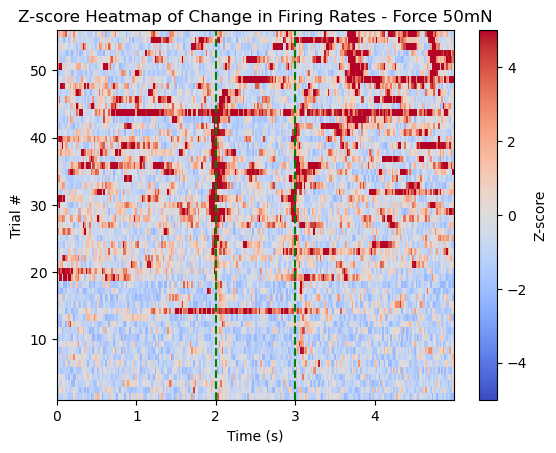

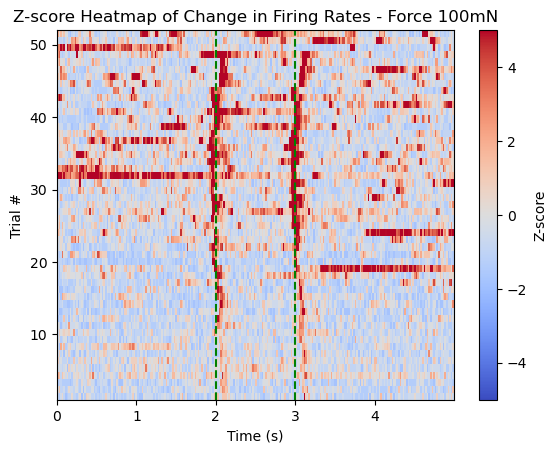

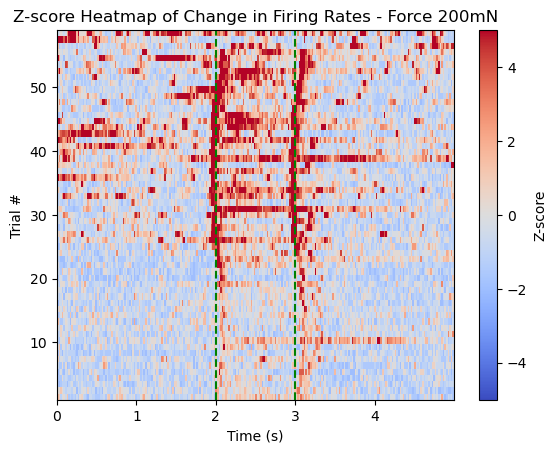

In [67]:
#Plot average response from all mech trials for one expt (separated by force)
# Define trial parameters
sampleRate = 30000
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
mech_duration = 4.998
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram


total_trials = 0
change_in_firing_rates_list = []
baseline_firing_rates_list = []
all_mechTrialForce = []

expt = 'ALC6_day1'
selected_units = np.concatenate(expts_selected_units[expt])

goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)

#Test if expt has require trials in dataset
if mechTrialForce is None or mech_duration is None:
    hasMech = False
else:
    hasMech = True
if acRecField_duration is None or physio_duration is None or laser_duration is None:
    hasLaser = False
else:
    hasLaser = True

if hasMech and hasLaser:
    # Number of trials and bins
    num_trials = len(mechTrialForce)
    total_trials += num_trials
    all_mechTrialForce.extend(mechTrialForce)

    # Initialize arrays to store firing rates and stimulation signal
    change_in_firing_rates = np.zeros((num_trials, num_bins))
    baseline_firing_rates = np.zeros((num_trials, num_bins))

    # Process each trial
    for i in range(num_trials):
        start_index = i * int(sampleRate * mech_duration)
        end_index = (i + 1) * int(sampleRate * mech_duration)

        # Find indices within range
        trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                               & (goodSamples >= start_index)
                                               & (goodSamples <= end_index)]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Calculate the average firing rate in the first 2 seconds
        baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
        baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
        
        # Store firing rates for each trial
        change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
        baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]
    
    change_in_firing_rates_list.append(change_in_firing_rates)
    baseline_firing_rates_list.append(baseline_firing_rates)

#Concat into full-length arrays
all_change_in_firing_rates = np.concatenate(change_in_firing_rates_list)
all_baseline_firing_rates = np.concatenate(baseline_firing_rates_list)

# Assuming mechTrialForce is a NumPy array
unique_forces = np.unique(all_mechTrialForce)

#Make each force plot
for force in unique_forces:
    # Filter trials based on force
    force_indices = np.where(all_mechTrialForce == force)[0]
    force_change_in_firing_rates = all_change_in_firing_rates[force_indices, :]
    force_baseline_firing_rates = all_baseline_firing_rates[force_indices, :]

    # Z-score the change in firing rates
    z_scored_change = zmap(force_change_in_firing_rates, force_baseline_firing_rates, axis=0, ddof=1)

    # Plotting
    time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
    trial_axis = np.arange(1, len(force_indices) + 1)

    # Create a z-score heatmap
    plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(force_indices)],
                cmap='coolwarm', origin='lower', vmin=-5, vmax=5, interpolation='none')  # Centered colormap

    # Add stimulation onset, hold, and ramp-down lines
    plt.axvline(x=stim_onset, linestyle='--', color='green', label='Stimulation Onset')
    plt.axvline(x=stim_onset + stim_hold , linestyle='--', color='green', label='Ramp Down')

    plt.xlabel('Time (s)')
    plt.ylabel('Trial #')
    plt.colorbar(label='Z-score')
    plt.title(f'Z-score Heatmap of Change in Firing Rates - Force {force}mN')
    plt.show()

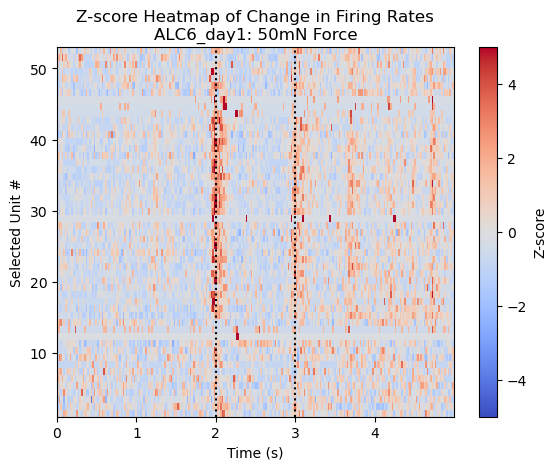

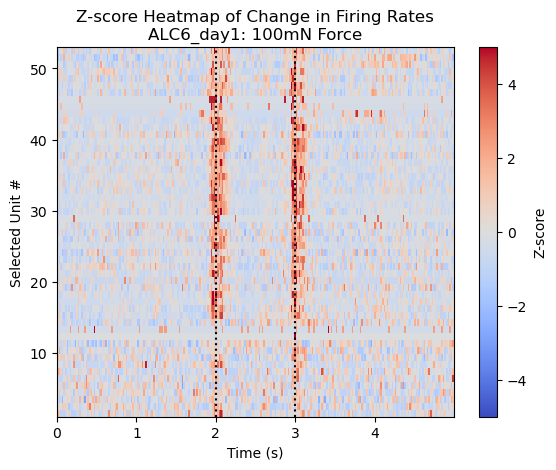

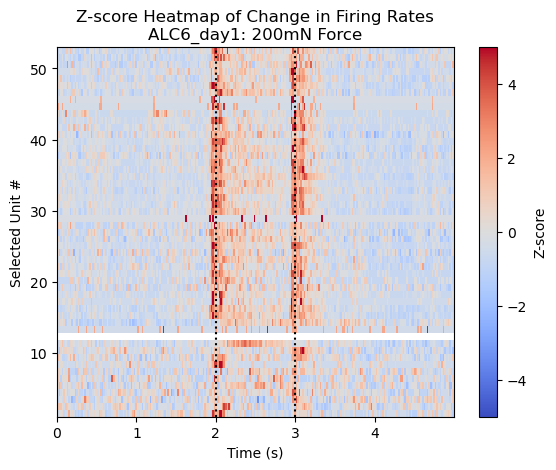

In [68]:
# Plot selected units from one experiment (expt) on the y-axis, separated by trial forces
expt = 'ALC6_day1'
selected_units = np.concatenate(expts_selected_units[expt])

goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)

# Define trial parameters
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
bin_factor = 0.02  # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor)  # bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1  # Number of bins for the histogram

# Initialize lists to store firing rates and stimulation signals
change_in_firing_rates_list = []
baseline_firing_rates_list = []


# Test if expt has required trials in dataset
if mechTrialForce is None or mech_duration is None:
    hasMech = False
else:
    hasMech = True
if acRecField_duration is None or physio_duration is None or laser_duration is None:
    hasLaser = False
else:
    hasLaser = True

if hasMech and hasLaser:
    # Initialize lists to store firing rates and stimulation signals
    change_in_firing_rates_list = []
    baseline_firing_rates_list = []

    # Assuming mechTrialForce is a NumPy array
    unique_forces = np.unique(mechTrialForce)

    # Plot each force level separately
    for force in unique_forces:
        # Filter trials based on force
        force_indices = np.where(mechTrialForce == force)[0]

        # Initialize arrays to store firing rates for each unit
        change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((len(force_indices), num_bins))
            unit_baseline_firing_rates = np.zeros((len(force_indices), num_bins))

            # Process each trial
            for j, trial_idx in enumerate(force_indices):
                start_index = trial_idx * int(sampleRate * mech_duration)
                end_index = (trial_idx + 1) * int(sampleRate * mech_duration)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]

                # Calculate firing rates for the trial using np.histogram
                firing_rates, bins = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        change_in_firing_rates_list.append(change_in_firing_rates)
        baseline_firing_rates_list.append(baseline_firing_rates)

        # Concatenate into full-length arrays if needed for further analysis/plots outside the loop
        all_change_in_firing_rates = np.concatenate(change_in_firing_rates_list)
        all_baseline_firing_rates = np.concatenate(baseline_firing_rates_list)

        # Plotting
        z_scored_change = zscore(change_in_firing_rates, axis=1)  # Z-score the change in firing rates

        # Create a z-score heatmap
        plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(selected_units)],
                   cmap='coolwarm', origin='lower', vmin=-5, vmax=5, interpolation='none')  # Centered colormap

        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black', label='Stimulation Onset')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black', label='Ramp Down')

        plt.xlabel('Time (s)')
        plt.ylabel('Selected Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'Z-score Heatmap of Change in Firing Rates\n{expt}: {force}mN Force')
        plt.show()


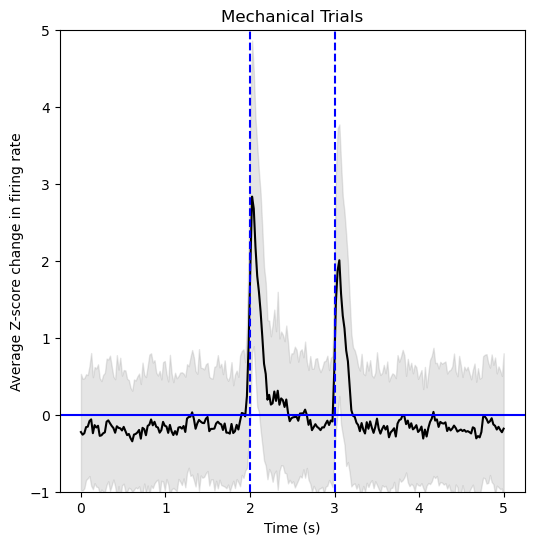

In [133]:
#Plot all mech trials grand averages, enriched units (unseparated by force)
# Define trial parameters
sampleRate = 30000
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
mech_duration = 4.998
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram
selected_unit = expts_selected_units


# Plotting
time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
unit_axis = np.arange(1, len(selected_units) + 1)

total_trials = 0
change_in_firing_rates_list = []
baseline_firing_rates_list = []
all_mechTrialForce = []
z_scored_changes_list = []

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        selected_units = np.concatenate(selected_unit[expt])

        #adjust for differences in trial start time
        mech_adjustment = 0
        if expt == 'ALC4_day3':
            mech_adjustment = -(30000*.04)
        if expt == 'ALC4_day4':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day1':
            mech_adjustment = -(30000*.05)
        if expt == 'ALC6_day2':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day3':
            mech_adjustment = (30000*.04)
        if expt == 'ALC6_day4':
            mech_adjustment = -(30000*.01)

        # Number of trials and bins
        num_trials = len(mechTrialForce)
        total_trials += num_trials
        all_mechTrialForce.extend(mechTrialForce)

        # print(mech_duration)

        # Initialize arrays to store firing rates and stimulation signal
        change_in_firing_rates = np.zeros((num_trials, num_bins))
        baseline_firing_rates = np.zeros((num_trials, num_bins))

        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = j * int(sampleRate * mech_duration) + mech_adjustment
                end_index = (j + 1) * int(sampleRate * mech_duration) + mech_adjustment

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.mean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.mean(unit_baseline_firing_rates, axis=0)

        # Z-score the average change in firing rates
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)
        average_z_score = np.mean(z_scored_change, axis=0)
        #plt.plot(time_axis, average_z_score, color='grey') #optional: plot each day's avg z-score changes
        z_scored_changes_list.append(z_scored_change) #add to grand list of z-scored changes


combined_z_scored_change = np.concatenate(z_scored_changes_list, axis=0)
average_z_score = np.mean(combined_z_scored_change, axis=0)
std_dev_z_score = np.std(combined_z_scored_change, axis=0, ddof=1)

plt.figure(figsize=(6, 6))
plt.ylim(-1, 5)
plt.plot(time_axis, average_z_score, color='black', label='Grand Average Z-score')
plt.fill_between(time_axis,
                average_z_score - std_dev_z_score,
                average_z_score + std_dev_z_score,
                color='gray', alpha=0.2, label='±1 StDev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='blue') #label='Stimulation Onset'
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='blue') #label='Ramp Down'
plt.axhline(y=0, linestyle='-', color='blue') #label='Stimulation Onset'

plt.xlabel('Time (s)')
plt.ylabel('Average Z-score change in firing rate')
plt.title(f'Mechanical Trials')
#plt.legend()

plt.show()


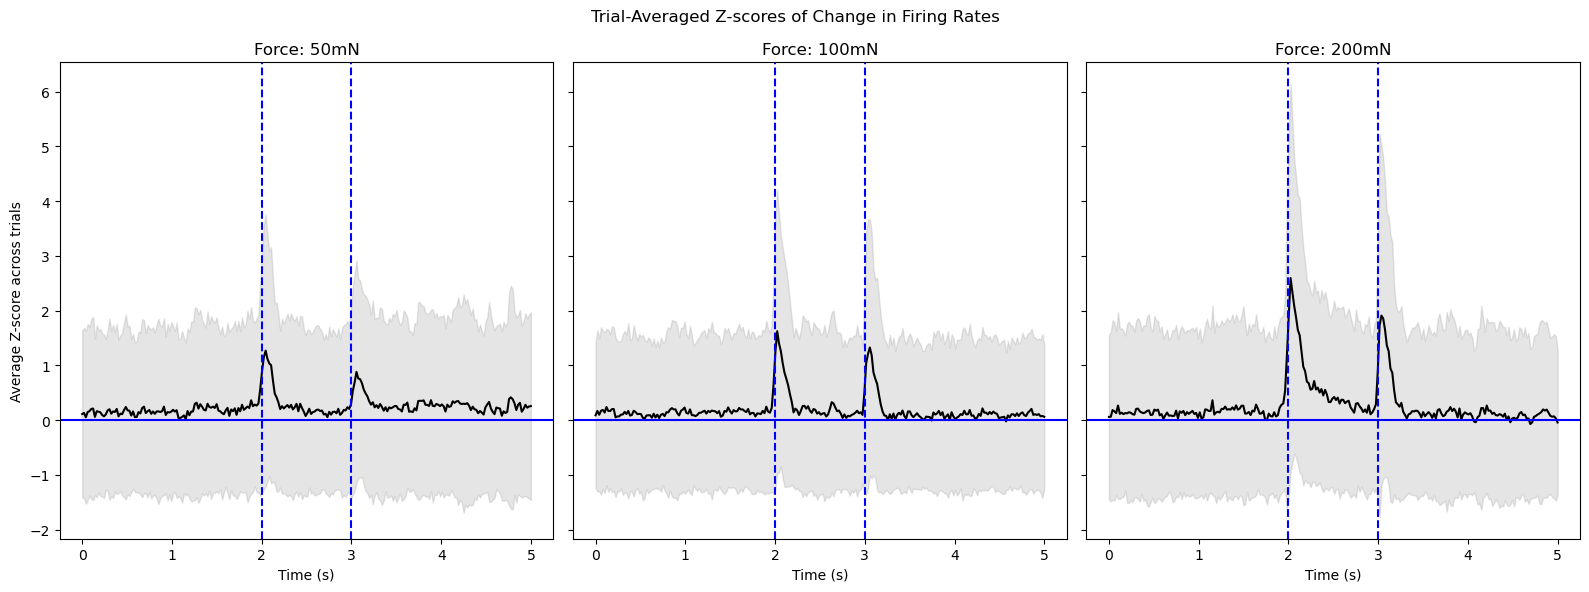

In [85]:
#plot trial averages sep by force (selected units)
#Define trial parameters
sampleRate = 30000
stim_onset = 2  # second
stim_ramp_down = 3  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds
mech_duration = 4.9983
bin_factor = 0.02 # the actual bin size in seconds.
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(mech_duration / bin_factor) - 1 # Number of bins for the histogram
selected_unit = expts_selected_units


total_trials = 0
change_in_firing_rates_list = []
baseline_firing_rates_list = []
all_mechTrialForce = []

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        # Number of trials and bins
        num_trials = len(mechTrialForce)
        total_trials += num_trials
        all_mechTrialForce.extend(mechTrialForce)
        selected_units = np.concatenate(selected_unit[expt])

        #adjust for differences in trial start time
        mech_adjustment = 0
        if expt == 'ALC4_day3':
            mech_adjustment = -(30000*.04)
        if expt == 'ALC4_day4':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day1':
            mech_adjustment = -(30000*.05)
        if expt == 'ALC6_day2':
            mech_adjustment = (30000*.00)
        if expt == 'ALC6_day3':
            mech_adjustment = (30000*.04)
        if expt == 'ALC6_day4':
            mech_adjustment = -(30000*.01)

        # Initialize arrays to store firing rates and stimulation signal
        change_in_firing_rates = np.zeros((num_trials, num_bins))
        baseline_firing_rates = np.zeros((num_trials, num_bins))

        # Process each trial
        for i in range(num_trials):
            start_index = i * int(sampleRate * mech_duration) + mech_adjustment
            end_index = (i + 1) * int(sampleRate * mech_duration) + mech_adjustment

            # Find indices within range
            trial_spikes_selected_units = goodSamples[np.isin(goodSpikes, selected_units)
                                                & (goodSamples >= start_index)
                                                & (goodSamples <= end_index)]

            # Calculate firing rates for the trial using np.histogram
            firing_rates, bins = np.histogram(trial_spikes_selected_units, bins=np.arange(start_index, end_index + bin_size, bin_size))

            # Calculate the average firing rate in the first 2 seconds
            baseline_firing_rate = np.mean(firing_rates[:int(2 / bin_factor)])
            baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)
            
            # Store firing rates for each trial
            change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin
            baseline_firing_rates[i, :] = baseline_firing_rate[:num_bins]
        
        change_in_firing_rates_list.append(change_in_firing_rates)
        baseline_firing_rates_list.append(baseline_firing_rates)

all_change_in_firing_rates = np.concatenate(change_in_firing_rates_list)
all_baseline_firing_rates = np.concatenate(baseline_firing_rates_list)

# Assuming mechTrialForce is a NumPy array
unique_forces = np.unique(all_mechTrialForce)
# Calculate the number of subplots needed based on the number of unique forces
num_subplots = len(unique_forces)
# Create subplots with shared y-axis
fig, axes = plt.subplots(1, num_subplots, figsize=(16, 6), sharey=True)

# Make each force plot
for i, force in enumerate(unique_forces):
    # Filter trials based on force
    force_indices = np.where(all_mechTrialForce == force)[0]
    force_change_in_firing_rates = all_change_in_firing_rates[force_indices, :]
    force_baseline_firing_rates = all_baseline_firing_rates[force_indices, :]
    
    # Z-score the change in firing rates
    z_scored_change = zmap(force_change_in_firing_rates, force_baseline_firing_rates, axis=0, ddof=1)
    
    # Calculate average z-scores for each force
    average_z_scores = np.mean(z_scored_change, axis=0)
    stdev_z_scores = np.std(z_scored_change, axis=0, ddof=1)

    # Plotting average z-scores on each subplot
    axes[i].plot(time_axis, average_z_scores, label=f'Avg: {force}mN trials', color='black')
    axes[i].fill_between(time_axis,
                         average_z_scores - stdev_z_scores,
                         average_z_scores + stdev_z_scores,
                         color='gray', alpha=0.2)
    
    # Add stimulation onset, hold, and ramp-down lines
    axes[i].axvline(x=stim_onset, linestyle='--', color='blue')
    axes[i].axvline(x=stim_onset + stim_hold, linestyle='--', color='blue')
    axes[i].axhline(y=0, linestyle='-', color='blue')
    
    axes[i].set_title(f'Force: {force}mN')
    axes[i].set_xlabel('Time (s)')
    if i == 0:
        axes[i].set_ylabel('Average Z-score across trials')
    # axes[i].set_title(f'Average Z-scores of Change in Firing Rates: {force}mN')
    #axes[i].legend()

# Adjust layout and show plot
fig.suptitle(f'Trial-Averaged Z-scores of Change in Firing Rates')
plt.tight_layout()
plt.show()

## 0.4 Plotting for physio experiment

In [54]:
def get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration, sampleRate = 30000):
    try:
        mech_trial_time = len(mechTrialForce) * mech_duration * sampleRate #duration in samples
    except TypeError:
        #if len(mechTrialForce is incalculable, it is a length of 0)
        mech_duration = 0 * mech_duration * sampleRate #duration in samples

    intertrial_buffer = 0 #int(1.00 * sampleRate)
    physio_start = mech_trial_time + acRecField_duration + intertrial_buffer#start sample number
    # physio_end = physio_start + physio_duration #end sample number


    pulse_start = physio_start + physio_duration
    # pulse_end = pulse_start + physio_duration

    return physio_start, pulse_start

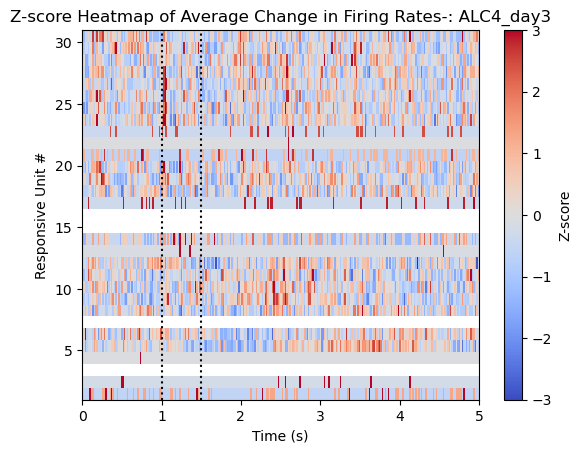

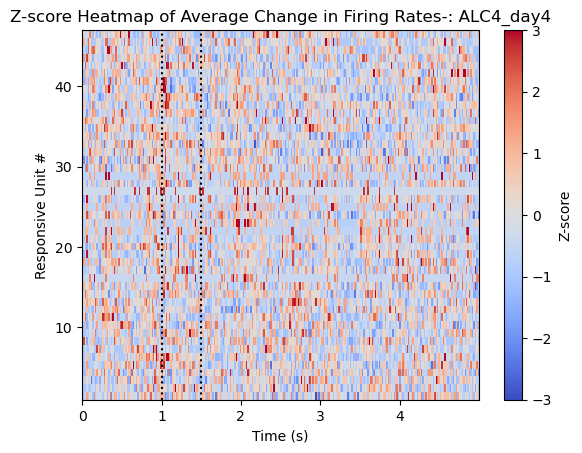

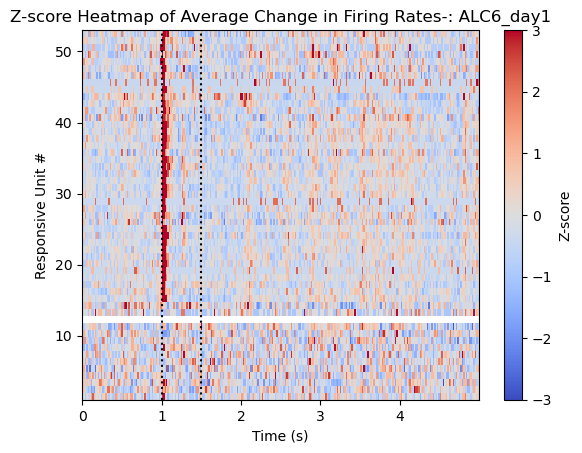

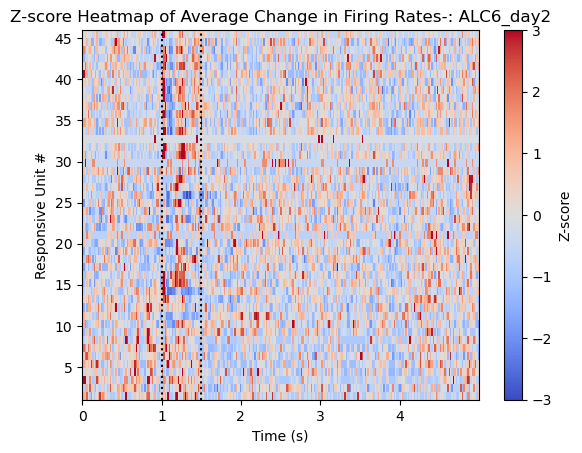

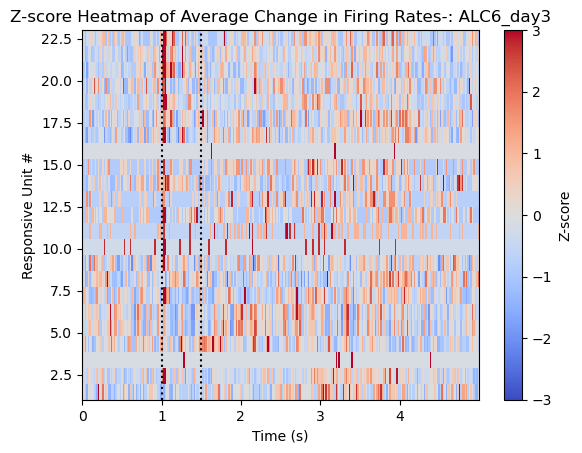

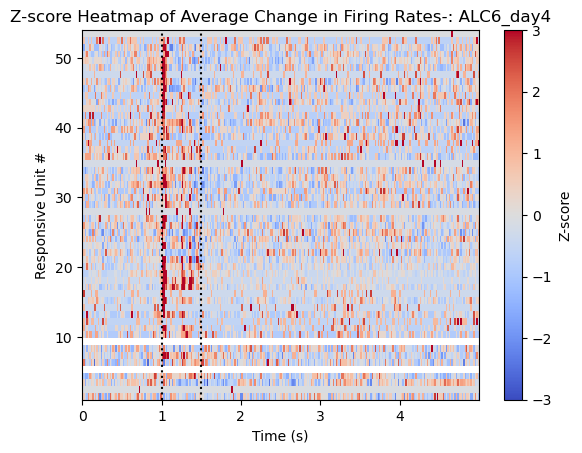

In [56]:
#plot physio trials by unit (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units

# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram


for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            physio_start -= (30000*.10)
        if expt == 'ALC4_day4':
            physio_start -= (30000*.13)
        if expt == 'ALC6_day1':
            physio_start -= (30000*.47)
        if expt == 'ALC6_day2':
            physio_start -= (30000*.10)
        if expt == 'ALC6_day3':
            physio_start -= (30000*.06)
        if expt == 'ALC6_day4':
            physio_start -= (30000*.13)


        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + physio_start)
                end_index = ((j + 1) * int(sampleRate * laser_time) + physio_start)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
        unit_axis = np.arange(1, len(selected_units) + 1)
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(selected_units)],
                cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap

        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'Z-score Heatmap of Average Change in Firing Rates-: {expt}')
        plt.show()

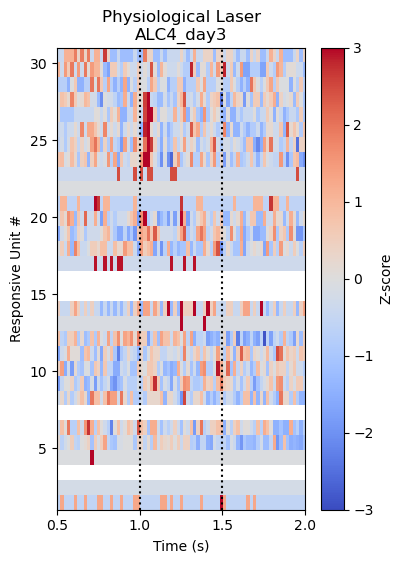

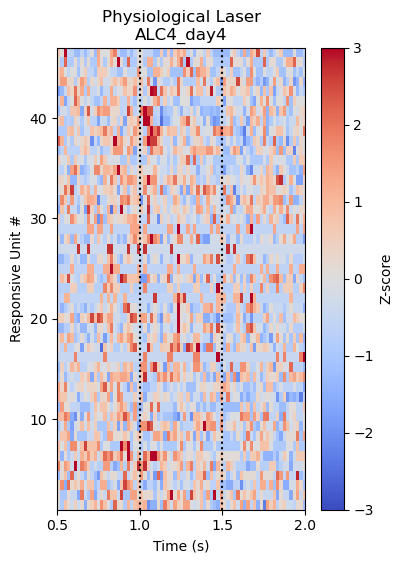

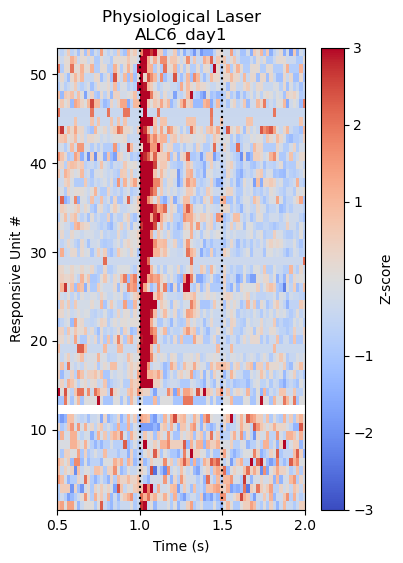

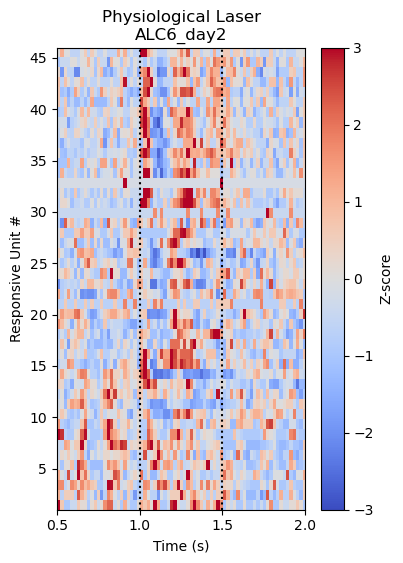

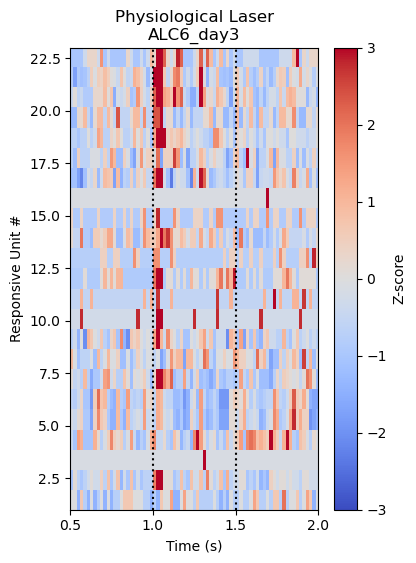

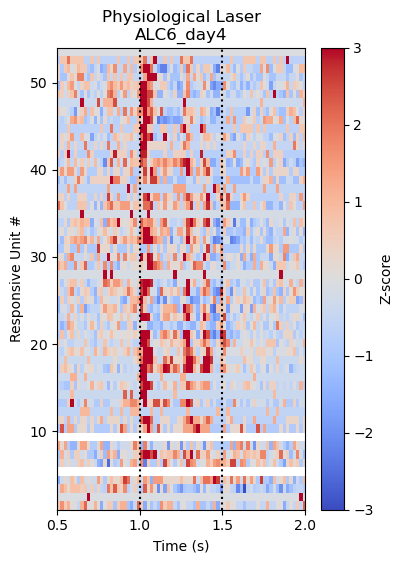

In [126]:
#TRUNCATED plot physio trials by unit (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units

# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram

# Plotting
# Define the time range you want to plot (between 2 and 4 seconds)
start_time = 0.5
end_time = 2
# Find the corresponding indices in the time_axis array
plot_start_bin = int(start_time / bin_factor)
plot_end_bin = int(end_time / bin_factor)


for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            physio_start -= (30000*.00)
        if expt == 'ALC4_day4':
            physio_start -= (30000*.03)
        if expt == 'ALC6_day1':
            physio_start -= (30000*.37)
        if expt == 'ALC6_day2':
            physio_start -= (30000*.00)
        if expt == 'ALC6_day3':
            physio_start += (30000*.04)
        if expt == 'ALC6_day4':
            physio_start -= (30000*.03)


        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + physio_start)
                end_index = ((j + 1) * int(sampleRate * laser_time) + physio_start)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        plt.figure(figsize=(4, 6))
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change[:, plot_start_bin:plot_end_bin], aspect='auto', extent=[start_time, end_time, 1, len(selected_units)],
           cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap


        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'Physiological Laser\n{expt}')
        plt.show()

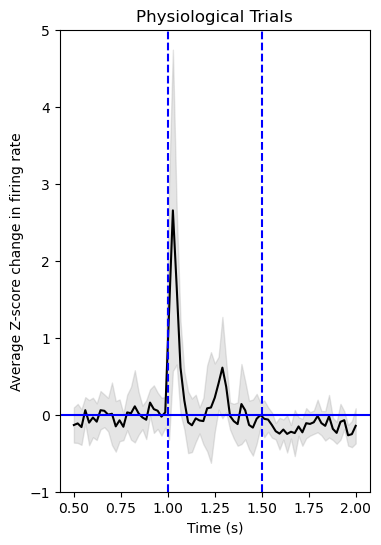

In [136]:
#plot physio trial averages (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units

# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram

# Plotting
# Define the time range you want to plot (between 2 and 4 seconds)
start_time = 0.5
end_time = 2
# Find the corresponding indices in the time_axis array
plot_start_bin = int(start_time / bin_factor)
plot_end_bin = int(end_time / bin_factor)


# time_axis = np.linspace(0, laser_time, int(laser_time / bin_factor) - 1)
time_axis_filtered = np.linspace(start_time, end_time, plot_end_bin - plot_start_bin)
z_scored_changes_list = []

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align (note: plotting this partial plot offsets the z-score lines by about 4 bins, hence the 0.1 second difference in adjustment values here.)
        if expt == 'ALC4_day3':
            physio_start -= (30000*.00)
        if expt == 'ALC4_day4':
            physio_start -= (30000*.03)
        if expt == 'ALC6_day1':
            physio_start -= (30000*.37)
        if expt == 'ALC6_day2':
            physio_start -= (30000*.00)
        if expt == 'ALC6_day3':
            physio_start += (30000*.04)
        if expt == 'ALC6_day4':
            physio_start -= (30000*.03)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + physio_start)
                end_index = ((j + 1) * int(sampleRate * laser_time) + physio_start)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)
        
        # Z-score the average change in firing rates
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)
        average_z_score = np.nanmean(z_scored_change, axis=0)
        average_z_score_filtered = average_z_score[plot_start_bin:plot_end_bin]
        #plt.plot(time_axis_filtered, average_z_score_filtered, color='grey') #optional: plot each day's avg z-score changes
        z_scored_changes_list.append(average_z_score_filtered) #add to grand list of z-scored changes

combined_z_scored_change = np.vstack(z_scored_changes_list)
grand_average_z_score = np.nanmean(combined_z_scored_change, axis=0)
std_dev_z_score = np.nanstd(combined_z_scored_change, axis=0, ddof=1)

plt.figure(figsize=(4, 6))
plt.ylim(-1, 5)
plt.plot(time_axis_filtered, grand_average_z_score, color='black', label='Grand Average Z-score')
plt.fill_between(time_axis_filtered,
                grand_average_z_score - std_dev_z_score,
                grand_average_z_score + std_dev_z_score,
                color='gray', alpha=0.2, label='±1 StDev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='blue') #label='Stimulation Onset'
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='blue') #label='Ramp Down'
plt.axhline(y=0, linestyle='-', color='blue') #label='Stimulation Onset'


plt.xlabel('Time (s)')
plt.ylabel('Average Z-score change in firing rate')
plt.title(f'Physiological Trials')
#plt.legend()

plt.show()


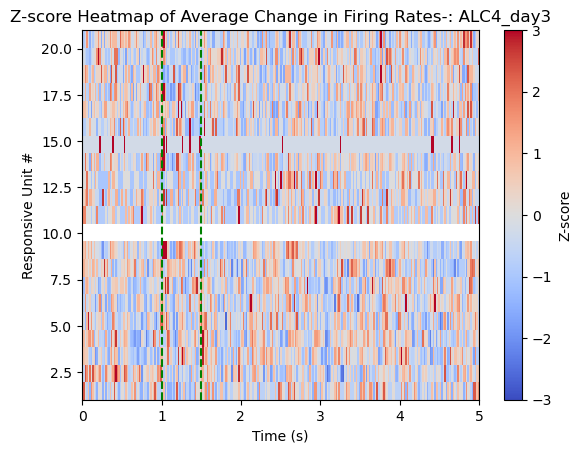

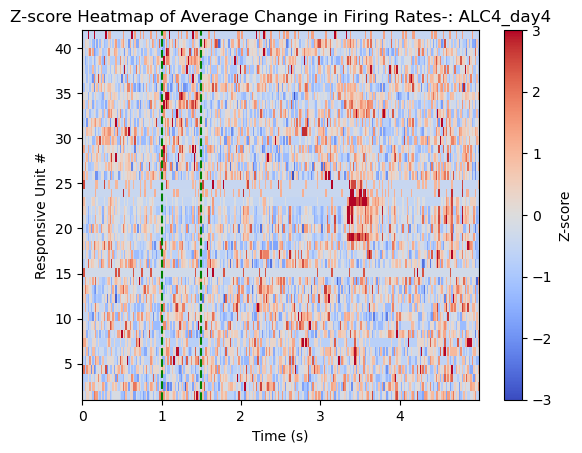

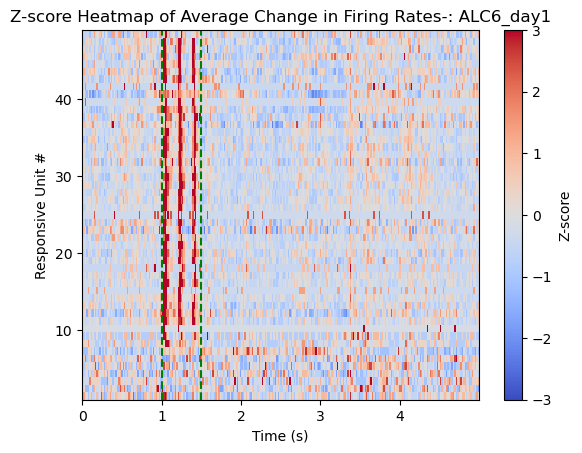

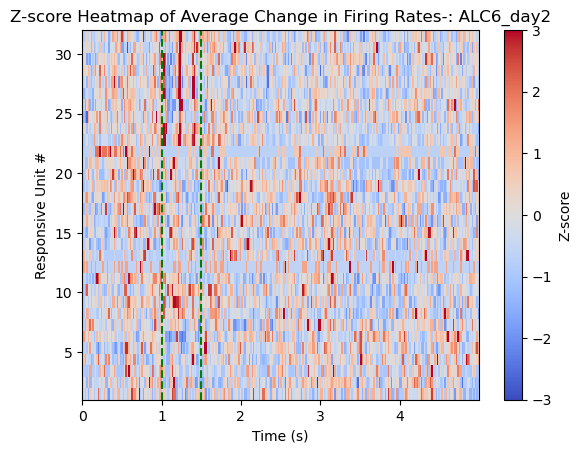

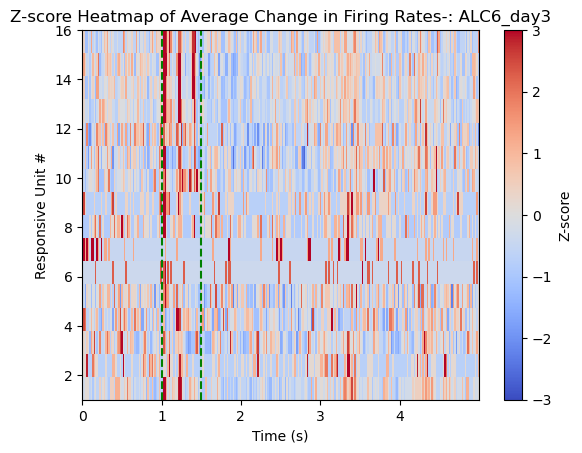

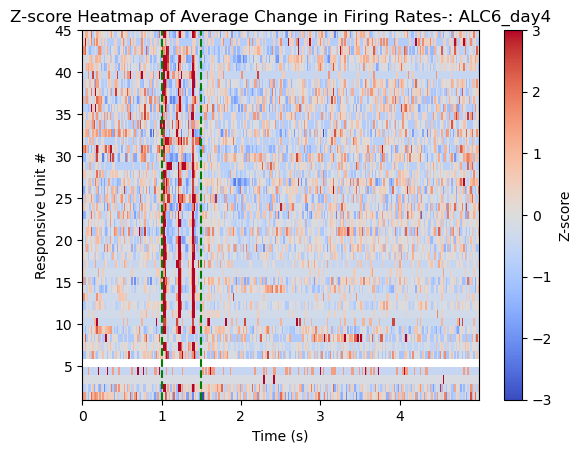

In [ ]:
#plot 5Hz pulsed trials by unit (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units

# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram


for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            pulse_start -= (30000*.10)
        if expt == 'ALC4_day4':
            pulse_start -= (30000*.13)
        if expt == 'ALC6_day1':
            pulse_start -= (30000*.44)
        if expt == 'ALC6_day2':
            pulse_start -= (30000*.12)
        if expt == 'ALC6_day3':
            pulse_start -= (30000*.08)
        if expt == 'ALC6_day4':
            pulse_start -= (30000*.13)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + pulse_start)
                end_index = ((j + 1) * int(sampleRate * laser_time) + pulse_start)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
        unit_axis = np.arange(1, len(selected_units) + 1)
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(selected_units)],
                cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap

        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle='--', color='green')
        plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='green')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'Z-score Heatmap of Average Change in Firing Rates-: {expt}')
        plt.show()

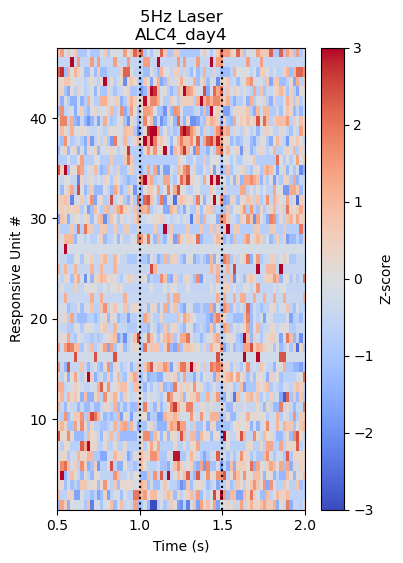

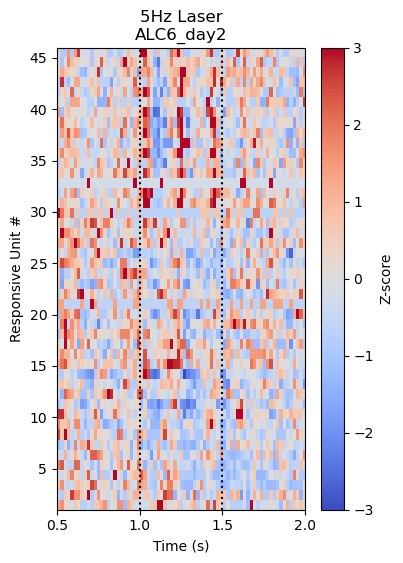

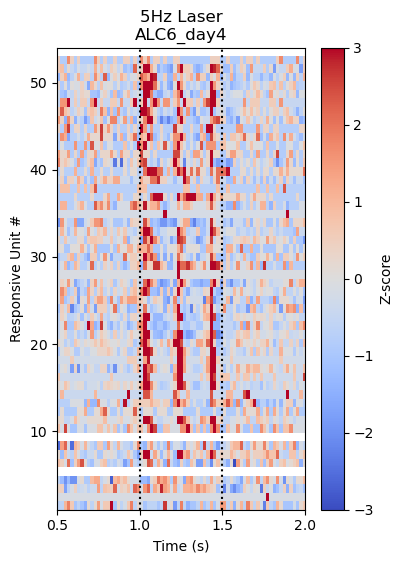

In [107]:
#TRUNCATED plot 5Hz pulsed trials by unit (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units

# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram

# Plotting
# Define the time range you want to plot (between 2 and 4 seconds)
start_time = 0.5
end_time = 2
# Find the corresponding indices in the time_axis array
plot_start_bin = int(start_time / bin_factor)
plot_end_bin = int(end_time / bin_factor)

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            pulse_start -= (30000*.00)
        if expt == 'ALC4_day4':
            pulse_start -= (30000*.03)
        if expt == 'ALC6_day1':
            pulse_start -= (30000*.34)
        if expt == 'ALC6_day2':
            pulse_start -= (30000*.02)
        if expt == 'ALC6_day3':
            pulse_start += (30000*.02)
        if expt == 'ALC6_day4':
            pulse_start -= (30000*.03)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + pulse_start)
                end_index = ((j + 1) * int(sampleRate * laser_time) + pulse_start)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        plt.figure(figsize=(4, 6))
        
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change[:, plot_start_bin:plot_end_bin], aspect='auto', extent=[start_time, end_time, 1, len(selected_units)],
           cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap


        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'5Hz Laser\n{expt}')
        plt.show()

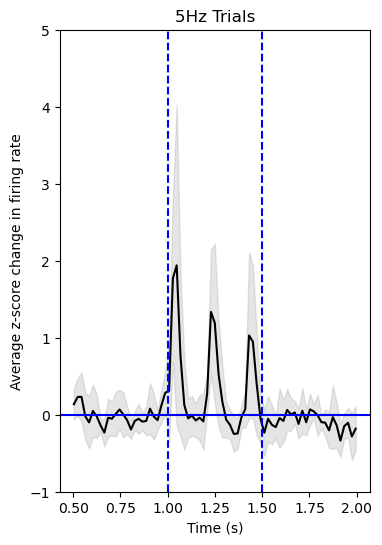

In [139]:
#plot 5Hz trial averages (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units


# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram

# Plotting
# Define the time range you want to plot (between 2 and 4 seconds)
start_time = 0.5
end_time = 2
# Find the corresponding indices in the time_axis array
time_axis = np.linspace(0, laser_time, int(laser_time / bin_factor) - 1)
plot_start_bin = int(start_time / bin_factor)
plot_end_bin = min(int(end_time / bin_factor), len(time_axis))
time_axis_filtered = time_axis[plot_start_bin:plot_end_bin]
z_scored_changes_list = []

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align (note: plotting this partial plot offsets the z-score lines by about 4 bins, hence the 0.1 second difference in adjustment values here.)
        if expt == 'ALC4_day3':
            pulse_start -= (30000*.00)
        if expt == 'ALC4_day4':
            pulse_start -= (30000*.03)
        if expt == 'ALC6_day1':
            pulse_start -= (30000*.34)
        if expt == 'ALC6_day2':
            pulse_start -= (30000*.02)
        if expt == 'ALC6_day3':
            pulse_start += (30000*.02)
        if expt == 'ALC6_day4':
            pulse_start -= (30000*.03)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + pulse_start)
                end_index = ((j + 1) * int(sampleRate * laser_time) + pulse_start)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)
        
        # Z-score the average change in firing rates
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)
        average_z_score = np.nanmean(z_scored_change, axis=0)
        average_z_score_filtered = average_z_score[plot_start_bin:plot_end_bin]
        #plt.plot(time_axis_filtered, average_z_score_filtered, color='grey') #optional: plot each day's avg z-score changes
        z_scored_changes_list.append(average_z_score_filtered) #add to grand list of z-scored changes

combined_z_scored_change = np.vstack(z_scored_changes_list)
grand_average_z_score = np.nanmean(combined_z_scored_change, axis=0)
std_dev_z_score = np.nanstd(combined_z_scored_change, axis=0, ddof=1)

plt.figure(figsize=(4, 6))
plt.ylim(-1, 5)
plt.plot(time_axis_filtered, grand_average_z_score, color='black', label='Grand Average Z-score')
plt.fill_between(time_axis_filtered,
                grand_average_z_score - std_dev_z_score,
                grand_average_z_score + std_dev_z_score,
                color='gray', alpha=0.2, label='±1 StDev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='blue') #label='Stimulation Onset'
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='blue') #label='Ramp Down'
plt.axhline(y=0, linestyle='-', color='blue') #label='Stimulation Onset'

plt.xlabel('Time (s)')
plt.ylabel('Average z-score change in firing rate')
plt.title(f'5Hz Trials')
#plt.legend()

plt.show()


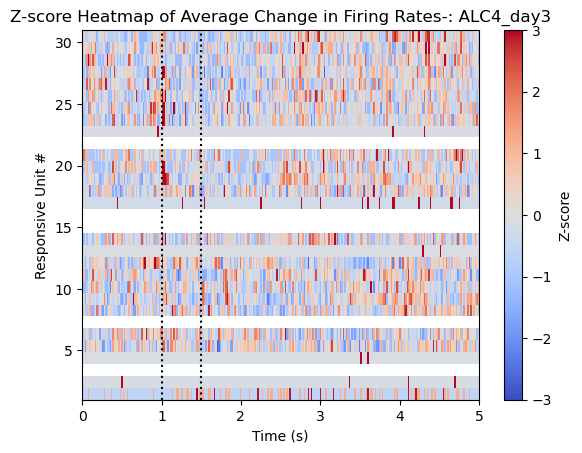

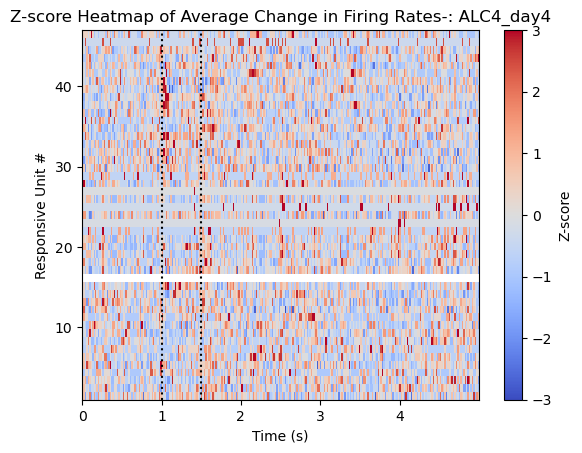

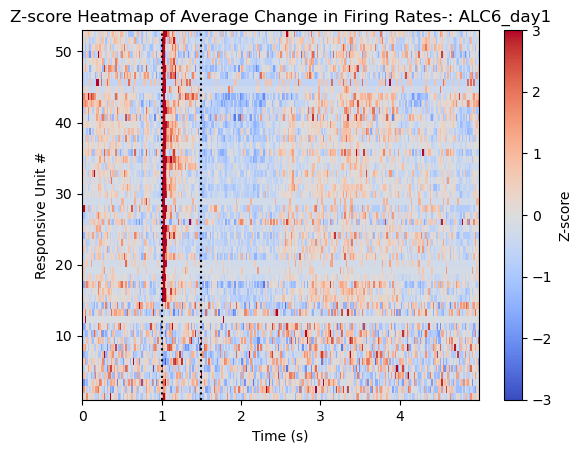

In [57]:
#plot 20Hz pulses trials by unit (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units

# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram


for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            pulse_start -= (30000*.12)
        if expt == 'ALC4_day4':
            pulse_start -= (30000*.04)
        if expt == 'ALC6_day1':
            pulse_start -= (30000*.35)
        if expt == 'ALC6_day2':
            pulse_start -= (30000*.15)
        if expt == 'ALC6_day3':
            pulse_start -= (30000*.15)
        if expt == 'ALC6_day4':
            pulse_start -= (30000*.13)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + pulse_start + physio_duration)
                end_index = ((j + 1) * int(sampleRate * laser_time) + pulse_start + physio_duration)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
        unit_axis = np.arange(1, len(selected_units) + 1)
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(selected_units)],
                cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap

        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'Z-score Heatmap of Average Change in Firing Rates-: {expt}')
        plt.show()

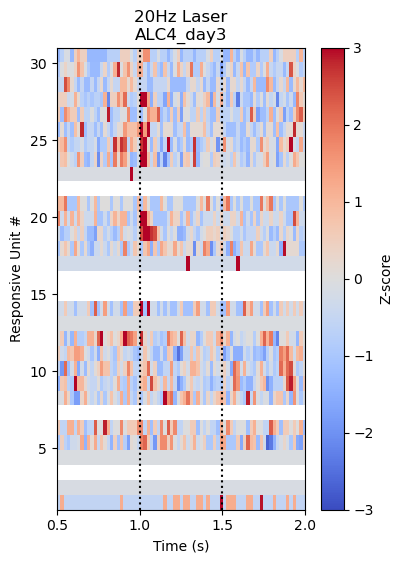

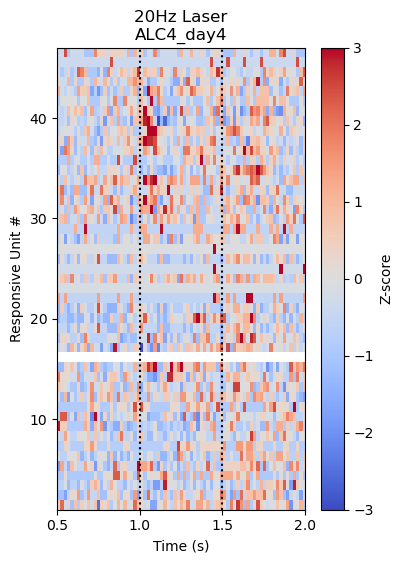

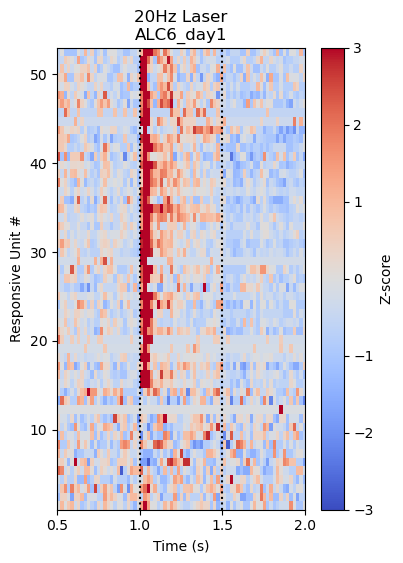

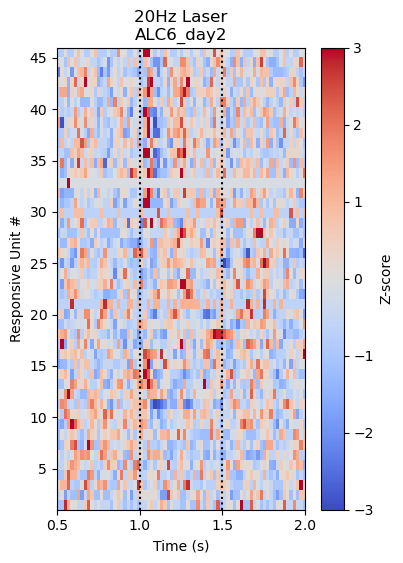

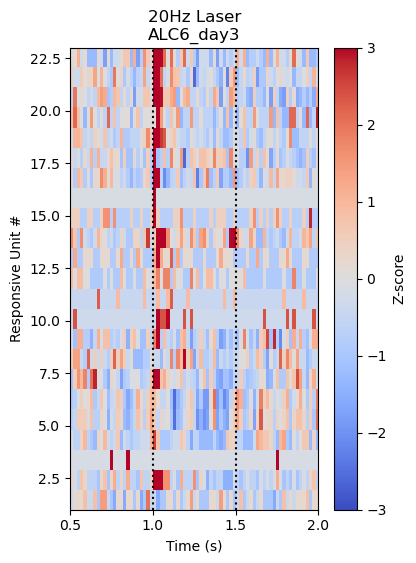

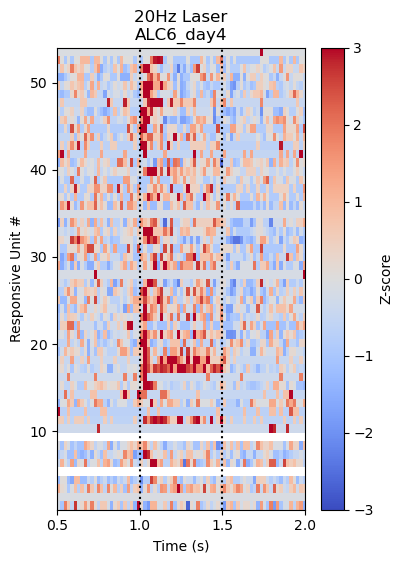

In [109]:
#TRUNCATED plot 20Hz pulses trials by unit (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units

# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram

# Plotting
# Define the time range you want to plot (between 2 and 4 seconds)
start_time = 0.5
end_time = 2
# Find the corresponding indices in the time_axis array
plot_start_bin = int(start_time / bin_factor)
plot_end_bin = int(end_time / bin_factor)


for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            pulse_start -= (30000*.02)
        if expt == 'ALC4_day4':
            pulse_start += (30000*.06)
        if expt == 'ALC6_day1':
            pulse_start -= (30000*.25)
        if expt == 'ALC6_day2':
            pulse_start -= (30000*.05)
        if expt == 'ALC6_day3':
            pulse_start -= (30000*.05)
        if expt == 'ALC6_day4':
            pulse_start -= (30000*.03)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + pulse_start + physio_duration)
                end_index = ((j + 1) * int(sampleRate * laser_time) + pulse_start + physio_duration)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        plt.figure(figsize=(4, 6))
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change[:, plot_start_bin:plot_end_bin], aspect='auto', extent=[start_time, end_time, 1, len(selected_units)],
           cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap


        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'20Hz Laser\n{expt}')
        plt.show()

In [142]:
#plot 20Hz trial averages (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units


# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram

# Plotting
# Define the time range you want to plot (between 2 and 4 seconds)
start_time = 0.5
end_time = 2
# Find the corresponding indices in the time_axis array
time_axis = np.linspace(0, laser_time, int(laser_time / bin_factor) - 1)
plot_start_bin = int(start_time / bin_factor)
plot_end_bin = min(int(end_time / bin_factor), len(time_axis))
time_axis_filtered = time_axis[plot_start_bin:plot_end_bin]
z_scored_changes_list = []

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            pulse_start -= (30000*.02)
        if expt == 'ALC4_day4':
            pulse_start += (30000*.06)
        if expt == 'ALC6_day1':
            pulse_start -= (30000*.25)
        if expt == 'ALC6_day2':
            pulse_start -= (30000*.05)
        if expt == 'ALC6_day3':
            pulse_start -= (30000*.05)
        if expt == 'ALC6_day4':
            pulse_start -= (30000*.03)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + pulse_start + physio_duration)
                end_index = ((j + 1) * int(sampleRate * laser_time) + pulse_start + physio_duration)

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)
        
        # Z-score the average change in firing rates
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)
        average_z_score = np.nanmean(z_scored_change, axis=0)
        average_z_score_filtered = average_z_score[plot_start_bin:plot_end_bin]
        #plt.plot(time_axis_filtered, average_z_score_filtered, color='grey') #optional: plot each day's avg z-score changes
        z_scored_changes_list.append(average_z_score_filtered) #add to grand list of z-scored changes

combined_z_scored_change = np.vstack(z_scored_changes_list)
grand_average_z_score = np.nanmean(combined_z_scored_change, axis=0)
std_dev_z_score = np.nanstd(combined_z_scored_change, axis=0, ddof=1)

plt.figure(figsize=(4, 6))
plt.ylim(-1, 5)
plt.plot(time_axis_filtered, grand_average_z_score, color='black', label='Grand Average Z-score')
plt.fill_between(time_axis_filtered,
                grand_average_z_score - std_dev_z_score,
                grand_average_z_score + std_dev_z_score,
                color='gray', alpha=0.2, label='±1 StDev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='blue') #label='Stimulation Onset'
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='blue') #label='Ramp Down'
plt.axhline(y=0, linestyle='-', color='blue') #label='Stimulation Onset'


plt.xlabel('Time (s)')
plt.ylabel('Average Z-score change in firing rate')
plt.title(f'20Hz Trials')
#plt.legend()

plt.show()

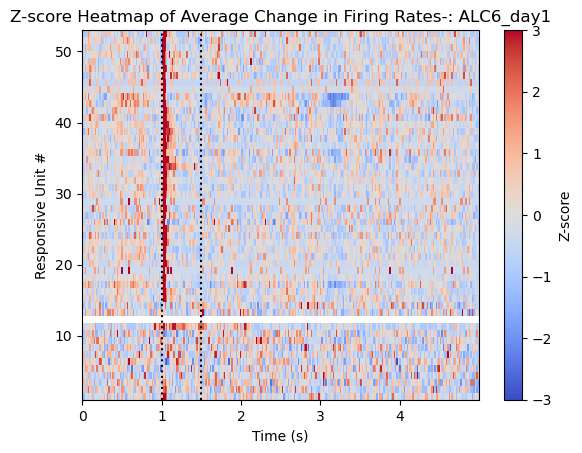

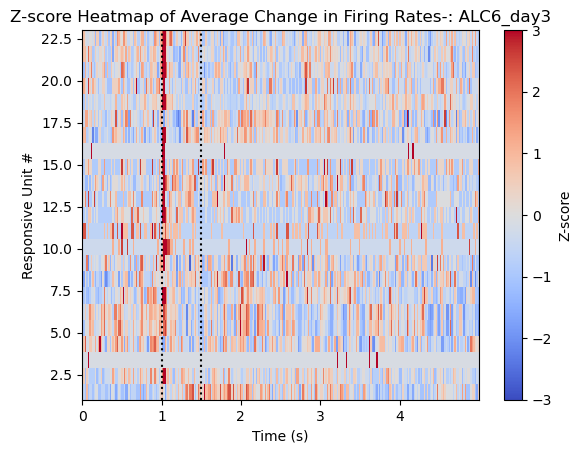

In [66]:
#plot 40Hz pulses trials by unit (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units


# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram


for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            pulse_start -= (30000*.09)
        if expt == 'ALC4_day4':
            pulse_start -= (30000*.03)
        if expt == 'ALC6_day1':
            pulse_start -= (30000*.35)
        if expt == 'ALC6_day2':
            pulse_start -= (30000*.18)
        if expt == 'ALC6_day3':
            pulse_start -= (30000*.21)
        if expt == 'ALC6_day4':
            pulse_start -= (30000*.13)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + pulse_start + (2*physio_duration))
                end_index = ((j + 1) * int(sampleRate * laser_time) + pulse_start + (2*physio_duration))

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        time_axis = np.linspace(0, mech_duration, int(mech_duration / bin_factor) - 1)
        unit_axis = np.arange(1, len(selected_units) + 1)
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change, aspect='auto', extent=[0, mech_duration, 1, len(selected_units)],
                cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap

        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'Z-score Heatmap of Average Change in Firing Rates-: {expt}')
        plt.show()

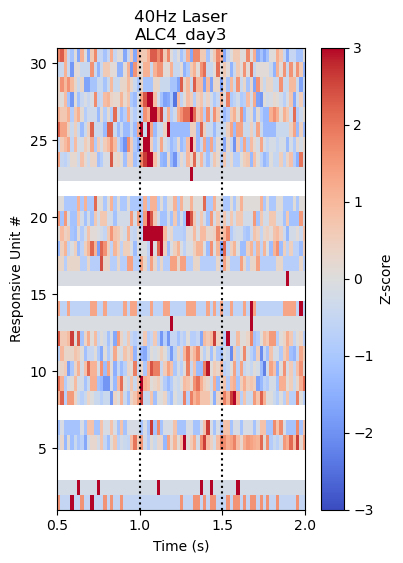

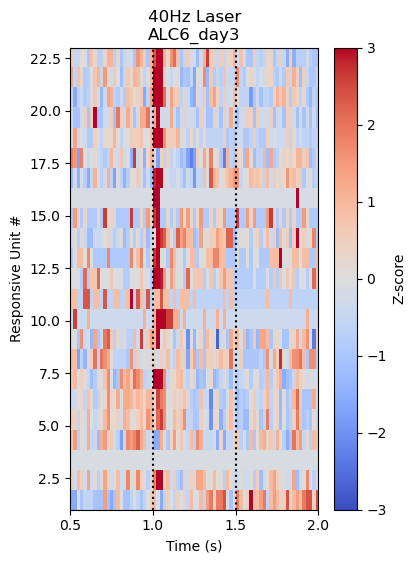

In [111]:
#TRUNCATED plot 40Hz pulses trials by unit (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units


# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram

# Plotting
# Define the time range you want to plot (between 2 and 4 seconds)
start_time = 0.5
end_time = 2
# Find the corresponding indices in the time_axis array
plot_start_bin = int(start_time / bin_factor)
plot_end_bin = int(end_time / bin_factor)

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            pulse_start += (30000*.01)
        if expt == 'ALC4_day4':
            pulse_start += (30000*.07)
        if expt == 'ALC6_day1':
            pulse_start -= (30000*.25)
        if expt == 'ALC6_day2':
            pulse_start -= (30000*.08)
        if expt == 'ALC6_day3':
            pulse_start -= (30000*.11)
        if expt == 'ALC6_day4':
            pulse_start -= (30000*.03)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + pulse_start + (2*physio_duration))
                end_index = ((j + 1) * int(sampleRate * laser_time) + pulse_start + (2*physio_duration))

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)

        # Plotting
        plt.figure(figsize=(4, 6))
        
        #z_scored_change = zmap(average_change_in_firing_rates, average_baseline_firing_rates, axis=0, ddof=1)
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)

        plt.imshow(z_scored_change[:, plot_start_bin:plot_end_bin], aspect='auto', extent=[start_time, end_time, 1, len(selected_units)],
           cmap='coolwarm', origin='lower', vmin=-3, vmax=3, interpolation='none')  # Centered colormap


        # Add stimulation onset, hold, and ramp-down lines
        plt.axvline(x=stim_onset, linestyle=':', color='black')
        plt.axvline(x=stim_onset + stim_hold, linestyle=':', color='black')

        plt.xlabel('Time (s)')
        plt.ylabel('Responsive Unit #')
        plt.colorbar(label='Z-score')
        plt.title(f'40Hz Laser\n{expt}')
        plt.show()

In [145]:
#plot 40Hz trial averages (enriched units)
#global parameters
laser_time = 5.5  # seconds
stim_onset = 1  # second
stim_hold = 0.5  # seconds
stim_ramp_down = stim_onset + stim_hold  # seconds
bin_factor = 0.02 # the actual bin size in seconds.
selected_unit = expts_selected_units


# Number of trials
num_trials = 50
bin_size = int(sampleRate * bin_factor) #bin size in samples.
num_bins = int(laser_time / bin_factor) - 1 # Number of bins for the histogram

# Plotting
# Define the time range you want to plot (between 2 and 4 seconds)
start_time = 0.5
end_time = 2
# Find the corresponding indices in the time_axis array
time_axis = np.linspace(0, laser_time, int(laser_time / bin_factor) - 1)
plot_start_bin = int(start_time / bin_factor)
plot_end_bin = min(int(end_time / bin_factor), len(time_axis))
time_axis_filtered = time_axis[plot_start_bin:plot_end_bin]
z_scored_changes_list = []

for expt in expts:
    goodSamples, goodSpikes, goodTimes, sampleRate, depths, clusterIDs, mechTrialForce, mech_duration, acRecField_duration, physio_duration, laser_duration = loadExperiment(expt, data_dict)    # Define trial parameters
    
    #Test if expt has require trials in dataset
    if mechTrialForce is None or mech_duration is None:
        hasMech = False
    else:
        hasMech = True
    if acRecField_duration is None or physio_duration is None or laser_duration is None:
        hasLaser = False
    else:
        hasLaser = True
    
    if hasMech and hasLaser:
        physio_start, pulse_start = get_laser_indices(mechTrialForce, mech_duration, acRecField_duration, physio_duration)
        
        #adjustments to align
        if expt == 'ALC4_day3':
            pulse_start += (30000*.01)
        if expt == 'ALC4_day4':
            pulse_start += (30000*.07)
        if expt == 'ALC6_day1':
            pulse_start -= (30000*.25)
        if expt == 'ALC6_day2':
            pulse_start -= (30000*.08)
        if expt == 'ALC6_day3':
            pulse_start -= (30000*.11)
        if expt == 'ALC6_day4':
            pulse_start -= (30000*.03)

        selected_units = np.concatenate(selected_unit[expt]) #np.unique(goodSpikes) 
        
        
        # Initialize arrays to store average change in firing rates for each unit
        average_change_in_firing_rates = np.zeros((len(selected_units), num_bins))
        average_baseline_firing_rates = np.zeros((len(selected_units), num_bins))

        # Process each unit
        for i, unit in enumerate(selected_units):
            # Find spikes belonging to the current unit
            unit_spikes = goodSamples[goodSpikes == unit]

            # Initialize arrays to store firing rates for each trial
            unit_change_in_firing_rates = np.zeros((num_trials, num_bins))
            unit_baseline_firing_rates = np.zeros((num_trials, num_bins))

            # Process each trial
            for j in range(num_trials):
                start_index = (j * int(sampleRate * laser_time) + pulse_start + (2*physio_duration))
                end_index = ((j + 1) * int(sampleRate * laser_time) + pulse_start + (2*physio_duration))

                # Find spikes within the current trial
                trial_spikes = unit_spikes[(unit_spikes >= start_index) & (unit_spikes <= end_index)]
                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate firing rates for the trial using np.histogram
                firing_rates, _ = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

                # Calculate the average firing rate in the first 2 seconds
                baseline_firing_rate = np.mean(firing_rates[int(2 / bin_factor):int(5 / bin_factor)])
                baseline_firing_rate = np.full_like(firing_rates, baseline_firing_rate)

                # Store firing rates for each trial
                unit_change_in_firing_rates[j, :] = firing_rates[:num_bins]
                unit_baseline_firing_rates[j, :] = baseline_firing_rate[:num_bins]

            # Calculate the average change in firing rate for the unit
            average_change_in_firing_rates[i, :] = np.nanmean(unit_change_in_firing_rates, axis=0)
            average_baseline_firing_rates[i, :] = np.nanmean(unit_baseline_firing_rates, axis=0)
        
        # Z-score the average change in firing rates
        z_scored_change = zscore(average_change_in_firing_rates, axis=1)
        average_z_score = np.nanmean(z_scored_change, axis=0)
        average_z_score_filtered = average_z_score[plot_start_bin:plot_end_bin]
        #plt.plot(time_axis_filtered, average_z_score_filtered, color='grey') #optional: plot each day's avg z-score changes
        z_scored_changes_list.append(average_z_score_filtered) #add to grand list of z-scored changes

combined_z_scored_change = np.vstack(z_scored_changes_list)
grand_average_z_score = np.nanmean(combined_z_scored_change, axis=0)
std_dev_z_score = np.nanstd(combined_z_scored_change, axis=0, ddof=1)

plt.figure(figsize=(4, 6))
plt.ylim(-1, 5)
plt.plot(time_axis_filtered, grand_average_z_score, color='black', label='Grand Average Z-score')
plt.fill_between(time_axis_filtered,
                grand_average_z_score - std_dev_z_score,
                grand_average_z_score + std_dev_z_score,
                color='gray', alpha=0.2, label='±1 StDev')

# Add stimulation onset, hold, and ramp-down lines
plt.axvline(x=stim_onset, linestyle='--', color='blue') #label='Stimulation Onset'
plt.axvline(x=stim_onset + stim_hold, linestyle='--', color='blue') #label='Ramp Down'
plt.axhline(y=0, linestyle='-', color='blue') #label='Stimulation Onset'


plt.xlabel('Time (s)')
plt.ylabel('Average Z-score change in firing rate')
plt.title(f'40Hz Trials')
#plt.legend()

plt.show()
